# Setup

In [1]:
#Import Python libraries
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

#actually used in this script
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
import tensorflow as tf
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import scipy
from tensorflow import keras
import shap
from IPython.core.interactiveshell import InteractiveShell

#Set options for notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
InteractiveShell.ast_node_interactivity = 'all'

#Set seed for reproducability
seed = 111

In [2]:
#Define functions
def find_na_columns(df: pd.DataFrame):
    """
    Function to list columns that contain n/a's
    Input: df: pd.DataFrame
    Output: List of column names
    """
    na_cols = []
    for col in df:
        if df[col].isna().any():
            na_cols.append(col)
    return(na_cols)

#Imputation
def impute_values(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, group_column: str,  impute_value='mean'):
    """
    Function to impute missing values for numeric variables. Group column used to make imputations by mean more accurate.
    Input: train_df: pd.DataFrame, train data
            test_df: pd.DataFrame, test data
            column: str, column to impute
            group_column: str, column to group by for imputing
            impute_value: str ('mean', 'median')
    Output: dataframe with column with all missing values imputed to impute value
    """
    if impute_value == 'mean':
        subset = train_df[[column,group_column]].groupby(group_column).mean()
    elif impute_value == 'median':
        subset = train_df[[column,group_column]].groupby(group_column).median()
    elif impute_value == 'zero':
        df[column] = np.where(df[column].isna(), 0, df[column])
        return(df)
    else:
        raise Exception('That impute value is invalid. Options include mean or median.')
    subset = subset.reset_index()
    subset = subset.rename(columns={column: 'impute_val'})
    train_df = train_df.merge(subset, how='left', on=group_column)
    train_df[column] = np.where(train_df[column].isna(), train_df['impute_val'], train_df[column])
    train_df = train_df.drop('impute_val', axis=1)
    
    test_df = test_df.merge(subset, how='left', on=group_column)
    test_df[column] = np.where(test_df[column].isna(), test_df['impute_val'], test_df[column])
    test_df = test_df.drop('impute_val', axis=1)
    return(train_df, test_df)

def transformation_comparison(df: pd.DataFrame, column: str):
    """
    Function to create plots to compare log, min_max_scaler, and standard_scaler transformation of a 
    numeric column.
    
    Inputs: df: pd.DataFrame
            column: str, the name of a numeric column in the dataframe
            
    Outputs:
            None, print a plot showing a histogram of the data with different transformations
            
    Source: https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94
    """
    try:
        #If the column is strictly positive, use the box-cox method of power transformation
        if df[column].min() > 0:
            pt = PowerTransformer('box-cox')
        else:
            pt = PowerTransformer('yeo-johnson')
        fig, axes = plt.subplots(1,4, figsize=(15,3), constrained_layout=True)
        title_text = 'Comparing Transformations of '+column
        _ = fig.suptitle(title_text)
        _ = df.hist(column, ax = axes[0])
        #df['log_col'] = df[col].apply(lambda x: np.log(x+1))
        df[["PowerTransformed"]] = pd.DataFrame(pt.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('PowerTransformed', ax = axes[1])
        _ = plt.xlabel('Values')
        _ = plt.ylabel('Count')
        mms = MinMaxScaler()
        df[['MinMaxScaled']] = pd.DataFrame(mms.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('MinMaxScaled', ax = axes[2])
        ss = StandardScaler()
        df[['StandardScaled']] = pd.DataFrame(ss.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('StandardScaled', ax = axes[3])
        _ = plt.show()
    except:
        raise Exception(col, ' did not plot')

def remove_correlation(df: pd.DataFrame, target: str, threshold = .8):
    """
    Function to remove correlated columns. Find the columns that have a correlation above the absolute value of the
    threshold. Remove the column that is least correlated with the target variable until there are no more highly 
    correlated columns.
    Inputs:
        df: pd.DataFrame
        target: str, column name of target variable
        threshold: float, the correlation coefficient threshold to consider significant
    Outputs:
        pd.Dataframe with least correlated column removed
        list of dropped columns
    """
    corr_cols = ['placeholder']
    dropped_cols = []
    while len(corr_cols) > 0:
        correlation_matrix = df.corr()
        corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
        corr_df = corr_df.reset_index()
        corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
        corr_cols = corr_df_significant['level_0'].unique()
        if target in corr_cols:
            corr_cols.remove(target)
        if len(corr_cols) == 0:
            return(df, dropped_cols)
        subset = corr_df[(corr_df['level_0'] ==target)&(corr_df['level_1'].isin(corr_cols))]
        subset['correlation_coef'] = abs(subset['correlation_coef'])
        drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
        dropped_cols.append(drop_col)
        df = df.drop(drop_col, axis=1)

def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df['feature_importance'] > .01]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return(fi_df)

def regression_scatter(x: pd.Series, y: pd.Series, xlabel=None, ylabel=None, title=None, save_loc=None):
    """
    Function to create a scatter plot and calculate the r-squared term between x and y series
    
    INPUTS: x: pd.Series of x values
            y: pd.Series of y values
            xlabel: str, xlabel for plot
            ylabel: str, ylabel for plot
            title: str, title for plot
            save_loc: str, directory to save plot
    OUTPUT:
            graph image
    """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    ax = sns.regplot(x = x, y = y,
   line_kws = {
      'label': "R-squared: {}".format(round(r_value*r_value,3))
   })
    # plot legend
    _ = ax.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.title(title)
    _ = plt.show()
    
    if save_loc:
        plt.savefig(save_loc+'.png')
        
# Display training progress by printing a single dot for each completed epoch
# Code produced by Pierre Gentine and shared in ML For Environmental Engineering class
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
# Code produced by Pierre Gentine and shared in ML For Environmental Engineering class
def plot_history(history, title=None):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sq. Error')
    plt.title(title)
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])
    

# Data Cleaning and Preparation
* Correct data types
* Imputation (median by county)
* Remove correlated features

## Initial Exploration

In [3]:
#Read in data
df = pd.read_pickle('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/data/deepsolar_tract_clean.pkl')
#Print an overview of the data set
df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,education_doctoral_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,race_islander_rate,race_other_rate,race_two_more_rate,employ_rate,poverty_family_below_poverty_level_rate,heating_fuel_gas_rate,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_coal_coke_rate,heating_fuel_solar_rate,heating_fuel_other_rate,heating_fuel_none_rate,solar_panel_area_divided_by_area,solar_panel_area_per_capita,tile_count_residential,tile_count_nonresidential,solar_system_count_residential,solar_system_count_nonresidential,total_panel_area_residential,total_panel_area_nonresidential,median_household_income,electricity_price_residential,electricity_price_commercial,electricity_price_industrial,electricity_price_transportation,electricity_price_overall,electricity_consume_residential,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_total,household_count,average_household_size,housing_unit_count,housing_unit_occupied_count,housing_unit_median_value,housing_unit_median_gross_rent,lat,lon,elevation,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days,age_18_24_rate,age_25_34_rate,age_more_than_85_rate,age_75_84_rate,age_35_44_rate,age_45_54_rate,age_65_74_rate,age_55_64_rate,age_10_14_rate,age_15_17_rate,age_5_9_rate,household_type_family_rate,dropout_16_19_inschool_rate,occupation_construction_rate,occupation_public_rate,occupation_information_rate,occupation_finance_rate,occupation_education_rate,occupation_administrative_rate,occupation_manufacturing_rate,occupation_wholesale_rate,occupation_retail_rate,occupation_transportation_rate,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.52005,85,1911,28,19,16,0,6,88,6420,mn,154.37190,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,0.002858,0.97

In [4]:
#View how many unique FIPS there are - confirm that each row has a unique FIPS number
len(df['fips'].unique())

72537

In [5]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 168 entries, tile_count to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(46), object(3)
memory usage: 92.0+ MB


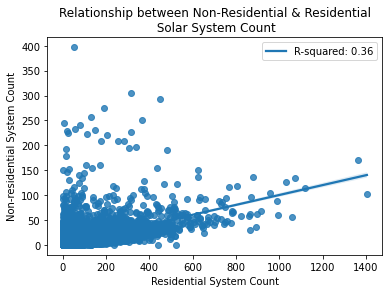

In [6]:
#Examine relationship between residential and non-residential solar system counts
regression_scatter(df['solar_system_count_residential'], df['solar_system_count_nonresidential'],
                   'Residential System Count', 'Non-residential System Count', 
                  'Relationship between Non-Residential & Residential\n Solar System Count')

In [7]:
#Confirm that the target variable is not missing any values
len(df[df['solar_system_count_nonresidential'].isna()])

0

In [8]:
#Examine the spread of the target variables
df['solar_system_count_nonresidential'].describe()

count    72537.000000
mean         2.602203
std          8.115283
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        397.000000
Name: solar_system_count_nonresidential, dtype: float64

In [9]:
#View percent of rows that have a value for non-residential solar system count - class imbalance 
round(len(df[df['solar_system_count_nonresidential']>0])/len(df),3)

0.479

## Data Type Correction

In [10]:
#Print list of categorical columns so they can be examined to see if they should be converted to float or
#encoded in a different way
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['county',
 'state',
 'electricity_price_transportation',
 'voting_2016_dem_win',
 'voting_2012_dem_win']

In [11]:
#Convert electricity_price_transportation to float - it is clearly numeric and was simply read in incorrectly
df['electricity_price_transportation'].value_counts()
df['electricity_price_transportation'] = pd.to_numeric(df['electricity_price_transportation'],errors='coerce')

         11899
8.99      8056
5.34      5265
12.95     4918
8.92      4245
7.82      3218
6.81      3123
7.69      2952
11.44     2813
7.9       2195
10.25     2010
5.27      1969
8.11      1907
9.4       1526
9.92      1511
7.76      1478
8.18      1458
14.66     1409
8.34      1406
8.36      1393
9.5       1338
10.08     1249
8.28      1148
9.14       834
13.18      833
9.11       687
11.21      686
10.05      588
18.54      244
9          179
Name: electricity_price_transportation, dtype: int64

In [12]:
#voting values are either false/true, encode these with binary 0/1 instead
df['voting_2016_dem_win'].value_counts()
df['voting_2016_dem_win'] = np.where(df['voting_2016_dem_win'] == True, 1, 
                                    np.where(df['voting_2016_dem_win'] == False, 0, -1))

True     39177
False    33360
Name: voting_2016_dem_win, dtype: int64

In [13]:
#voting values are either false/true, encode these with binary 0/1 instead
df['voting_2012_dem_win'].value_counts()
df['voting_2012_dem_win'] = np.where(df['voting_2012_dem_win'] == True, 1, 
                                    np.where(df['voting_2012_dem_win'] == False, 0, -1))

False    36986
True     35551
Name: voting_2012_dem_win, dtype: int64

In [14]:
#define the target variable
target_var = 'solar_system_count_nonresidential'
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']
look_ahead_vars.remove(target_var)
df = df.drop(look_ahead_vars, axis=1)

#Separate data into x and y
x = df[df.columns.difference([target_var])]
y = df[target_var]

#Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

#Rejoin label and data for some of the pre-processing steps
train_data = pd.concat([x_train, pd.DataFrame(y_train.values, columns = [target_var], index = y_train.index)], axis=1)
train_data.head()

test_data = pd.concat([x_test, pd.DataFrame(y_test.values, columns = [target_var], index = y_test.index)], axis=1)


,age_10_14_rate,age_15_17_rate,age_18_24_rate,age_25_34_rate,age_35_44_rate,age_45_54_rate,age_55_64_rate,age_5_9_rate,age_65_74_rate,age_75_84_rate,age_median,age_more_than_85_rate,air_temperature,atmospheric_pressure,average_household_income,average_household_size,avg_electricity_retail_rate,cooling_degree_days,cooling_design_temperature,cooperate_tax,county,daily_solar_radiation,diversity,dropout_16_19_inschool_rate,earth_temperature,earth_temperature_amplitude,education_bachelor,education_bachelor_rate,education_college,education_college_rate,education_doctoral,education_doctoral_rate,education_high_school_graduate,education_high_school_graduate_rate,education_less_than_high_school,education_less_than_high_school_rate,education_master,education_master_rate,education_population,education_professional_school,education_professional_school_rate,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_residential,electricity_consume_total,electricity_price_commercial,electricity_price_industrial,electricity_price_overall,electricity_price_residential,electricity_price_transportation,elevation,employ_rate,employed,feedin_tariff,fips,frost_days,gini_index,health_insurance_none_rate,health_insurance_public_rate,heating_degree_days,heating_design_temperature,heating_fuel_coal_coke,heating_fuel_coal_coke_rate,heating_fuel_electricity,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_gas,heating_fuel_gas_rate,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_none_rate,heating_fuel_other,heating_fuel_other_rate,heating_fuel_solar,heating_fuel_solar_rate,household_count,household_type_family_rate,housing_unit_count,housing_unit_median_gross_rent,housing_unit_median_value,housing_unit_occupied_count,incentive_count_nonresidential,incentive_count_residential,incentive_nonresidential_state_level,incentive_residential_state_level,land_area,lat,lon,median_household_income,mortgage_with_rate,net_metering,number_of_years_of_education,occupancy_owner_rate,occupancy_vacant_rate,occupation_administrative_rate,occupation_agriculture_rate,occupation_arts_rate,occupation_construction_rate,occupation_education_rate,occupation_finance_rate,occupation_information_rate,occupation_manufacturing_rate,occupation_public_rate,occupation_retail_rate,occupation_transportation_rate,occupation_wholesale_rate,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_below_poverty_level_rate,poverty_family_count,property_tax,race_asian,race_asian_rate,race_black_africa,race_black_africa_rate,race_indian_alaska,race_indian_alaska_rate,race_islander,race_islander_rate,race_other,race_other_rate,race_two_more,race_two_more_rate,race_white,race_white_rate,rebate,relative_humidity,sales_tax,state,total_area,transportation_bicycle_rate,transportation_car_alone_rate,transportation_carpool_rate,transportation_home_rate,transportation_motorcycle_rate,transportation_public_rate,transportation_walk_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,travel_time_average,travel_time_less_than_10_rate,unemployed,voting_2012_dem_percentage,voting_2012_dem_win,voting_2012_gop_percentage,voting_2016_dem_percentage,voting_2016_dem_win,voting_2016_gop_percentage,water_area,wind_speed,solar_system_count_nonresidential
40203,0.048618,0.033937,0.101430,0.188942,0.110010,0.142612,0.108866,0.060248,0.074357,0.043661,34.1,0.009724,8.6,96.6,62875.045454,2.33,7.25,659.0,21.96,0,Pierce County,3.35,0.501541,0.942584,9.0,14.81,678,0.190610,1162,0.326680,33,0.009277,1149,0.323025,184,0.051729,328,0.092213,3557,23,0.006466,6680,76502,964,84146,8.22,4.35,7.40,9.09,8.18,433.0,0.925342,2640,11,53053072312,70.0,0.4223,0.096142,0.384965,3430.0,-2.52,19,0.008636,1579,0.717727,0,0.000000,602,0.273636,2200,0,0.000000,0,0.000000,0,0.000000,2200,0.614091,2384,835.0,254300.0,2200,30,23,11,8,0.953812,47.

## Missing Values Imputation

In [15]:
#Find columns with missing values
na_cols = find_na_columns(df)
na_cols

['average_household_income',
 'gini_index',
 'land_area',
 'per_capita_income',
 'population_density',
 'total_area',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 'education_bachelor_rate',
 'education_master_rate',
 'education_professional_school_rate',
 'education_doctoral_rate',
 'race_white_rate',
 'race_black_africa_rate',
 'race_indian_alaska_rate',
 'race_asian_rate',
 'race_islander_rate',
 'race_other_rate',
 'race_two_more_rate',
 'employ_rate',
 'poverty_family_below_poverty_level_rate',
 'heating_fuel_gas_rate',
 'heating_fuel_electricity_rate',
 'heating_fuel_fuel_oil_kerosene_rate',
 'heating_fuel_coal_coke_rate',
 'heating_fuel_solar_rate',
 'heating_fuel_other_rate',
 'heating_fuel_none_rate',
 'median_household_income',
 'electricity_price_transportation',
 'average_household_size',
 'housing_unit_median_value',
 'housing_unit_median_gross_rent',
 'lat',
 'lon',
 'elevation',
 'heating_desig

In [16]:
#Impute columns with missing values using county level medians
for col in na_cols:
    train_data, test_data = impute_values(train_data, test_data, col,'county', 'median')

In [17]:
#Check to see if there any any columns remaining with missing values
na_cols = find_na_columns(train_data)
na_cols

['air_temperature',
 'atmospheric_pressure',
 'cooling_degree_days',
 'cooling_design_temperature',
 'daily_solar_radiation',
 'dropout_16_19_inschool_rate',
 'earth_temperature',
 'earth_temperature_amplitude',
 'electricity_price_transportation',
 'elevation',
 'frost_days',
 'heating_degree_days',
 'heating_design_temperature',
 'housing_unit_median_gross_rent',
 'housing_unit_median_value',
 'land_area',
 'lat',
 'lon',
 'median_household_income',
 'population_density',
 'relative_humidity',
 'total_area',
 'voting_2012_dem_percentage',
 'voting_2012_gop_percentage',
 'voting_2016_dem_percentage',
 'voting_2016_gop_percentage',
 'water_area',
 'wind_speed']

In [18]:
#Check the number of missing rows for each column. I will remove those columns with a signficant amount of 
#rows missing
for col in na_cols:
    print(col, ' has ', len(train_data[train_data[col].isna()]), ' missing')

air_temperature  has  5  missing
atmospheric_pressure  has  5  missing
cooling_degree_days  has  5  missing
cooling_design_temperature  has  5  missing
daily_solar_radiation  has  5  missing
dropout_16_19_inschool_rate  has  1  missing
earth_temperature  has  5  missing
earth_temperature_amplitude  has  5  missing
electricity_price_transportation  has  4302  missing
elevation  has  5  missing
frost_days  has  5  missing
heating_degree_days  has  5  missing
heating_design_temperature  has  5  missing
housing_unit_median_gross_rent  has  1  missing
housing_unit_median_value  has  1  missing
land_area  has  3  missing
lat  has  5  missing
lon  has  5  missing
median_household_income  has  1  missing
population_density  has  3  missing
relative_humidity  has  5  missing
total_area  has  3  missing
voting_2012_dem_percentage  has  4902  missing
voting_2012_gop_percentage  has  4902  missing
voting_2016_dem_percentage  has  3  missing
voting_2016_gop_percentage  has  3  missing
water_area  h

In [19]:
#Drop the columns that had almost 5,000 rows of missing data.
drop_cols = ['electricity_price_transportation','voting_2012_dem_percentage','voting_2012_gop_percentage']
train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [20]:
#Drop any remaining rows with n/a values
train_data = train_data.dropna()
len(train_data)
test_data = test_data.dropna()
len(test_data)

58018

14502

In [21]:
#Drop variables that are uninformative for the target variable
uninformative_vars = ['fips', 'county', 'state'] #'lat', 'lon'
train_data = train_data.drop(uninformative_vars, axis=1)
test_data = test_data.drop(uninformative_vars, axis=1)

## Remove Correlated Features

In [22]:
#Remove features that are correlated above 0.8 with another feature. Perform removal in a step-wise fashion, 
#removing one feature that is least correlated with the target variable at each iteration until all features have 
#correlation values below 0.8
train_data, dropped_cols = remove_correlation(train_data, target_var)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
#Drop these features from the test set (they were already dropped from the train set)
test_data = test_data.drop(dropped_cols, axis=1)

## Normalize/Standardize Data

In [25]:
#Examine power transformer methods: box-cox vs. yeo-johnson
# for col in train_data.columns:
#     if train_data[col].min() > 0:
#         print(col)
# pt = PowerTransformer('box-cox')
# pt2 = PowerTransformer('yeo-johnson')
# fig, axes = plt.subplots(1,2, figsize=(10,3), constrained_layout=True)
# _ = fig.suptitle('Comparing Power Transformation Methods on Housing Unit Median Value')
# train_data[["Box_Cox"]] = pd.DataFrame(pt.fit_transform(train_data[['median_household_income']]), columns=['median_household_income'])
# _ = train_data.hist('Box_Cox', ax = axes[0])
# train_data[["Yeo_Johnson"]] = pd.DataFrame(pt2.fit_transform(train_data[['median_household_income']]), columns=['median_household_income'])
# _ = train_data.hist('Yeo_Johnson', ax = axes[1])
# _ = plt.show()
# train_data.drop(["Box_Cox", "Yeo_Johnson"], axis=1)

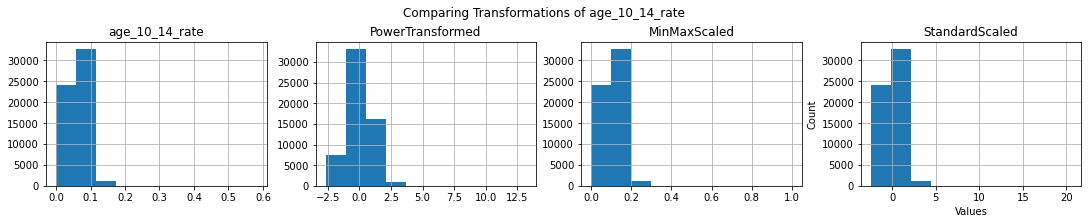

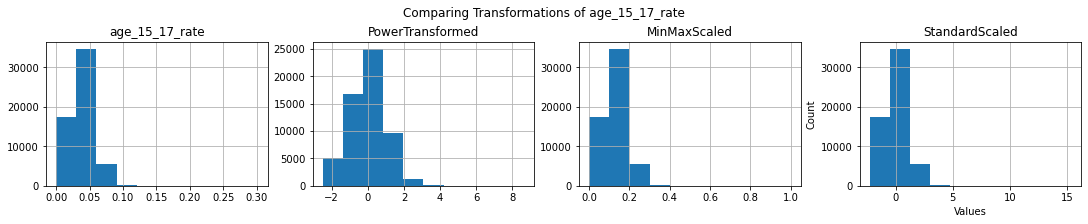

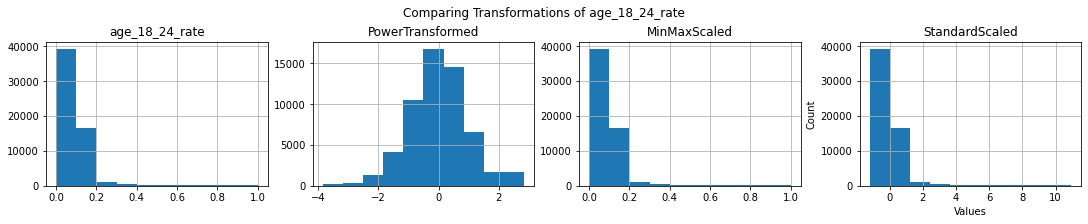

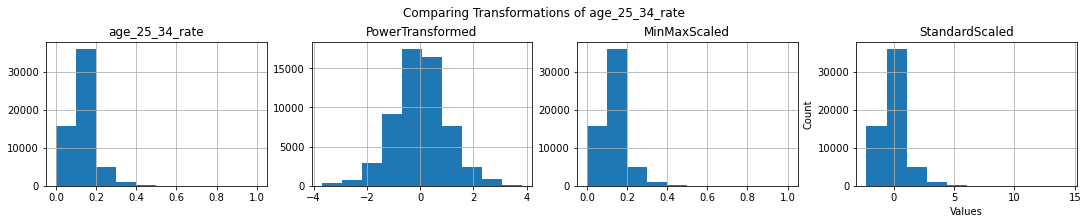

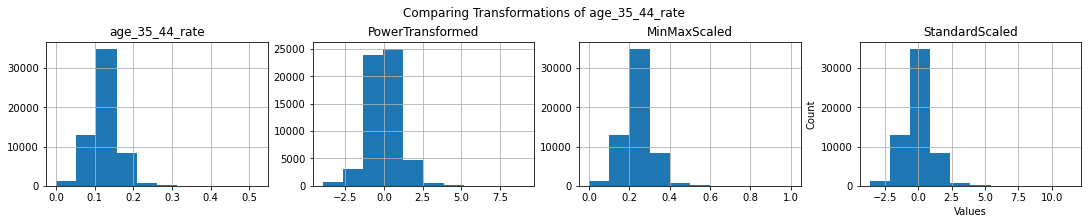

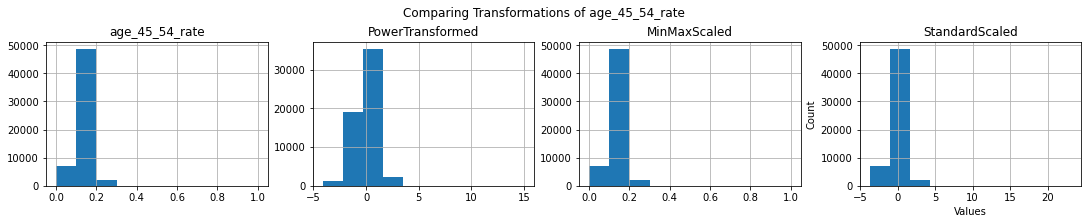

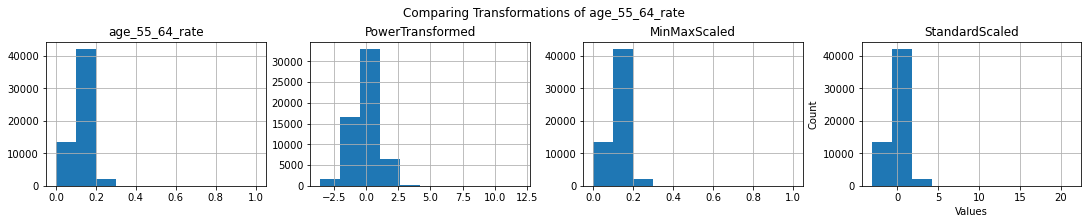

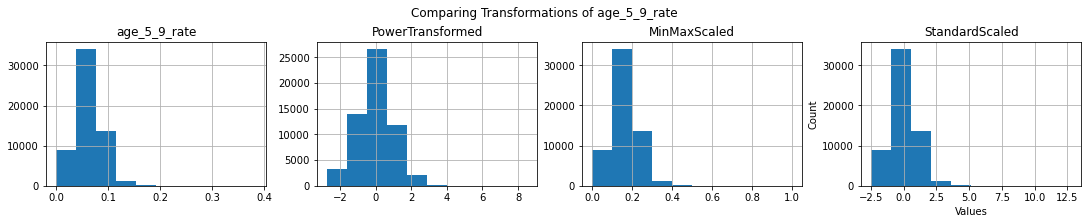

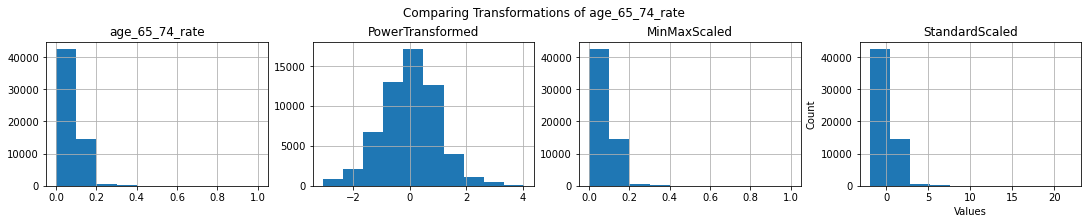

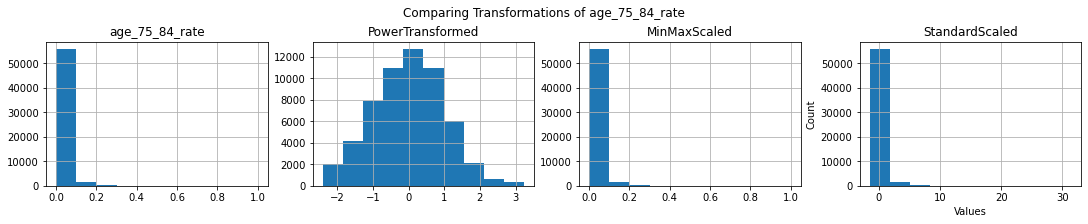

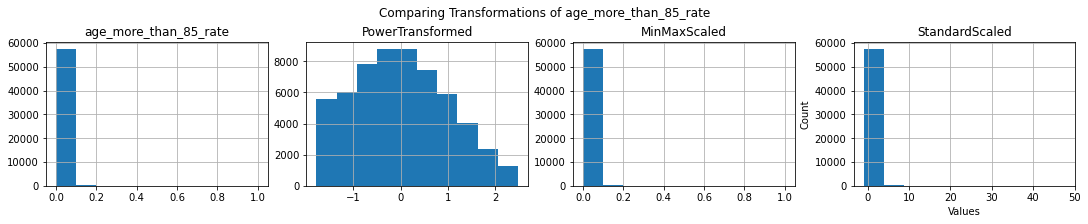

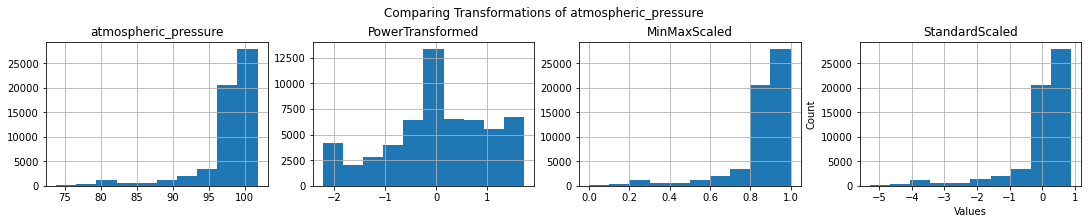

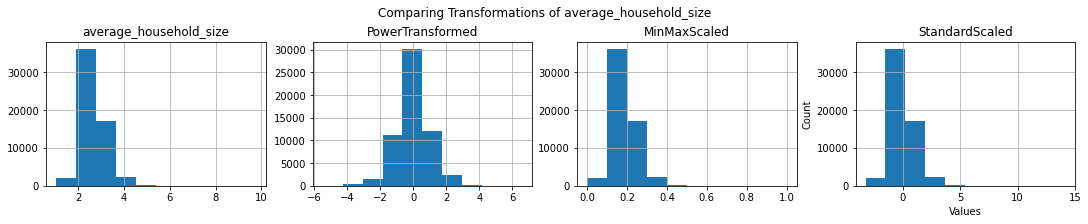

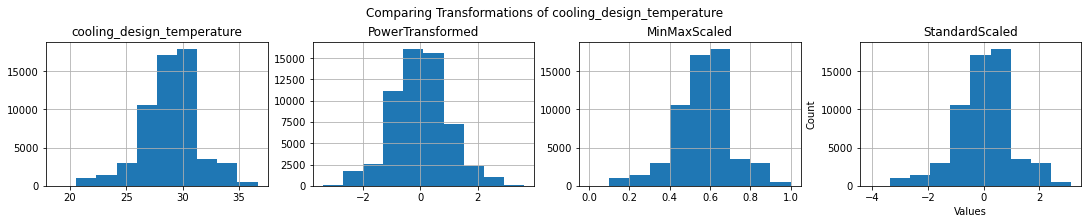

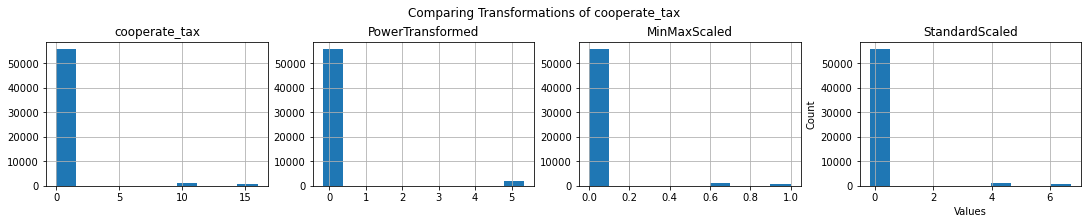

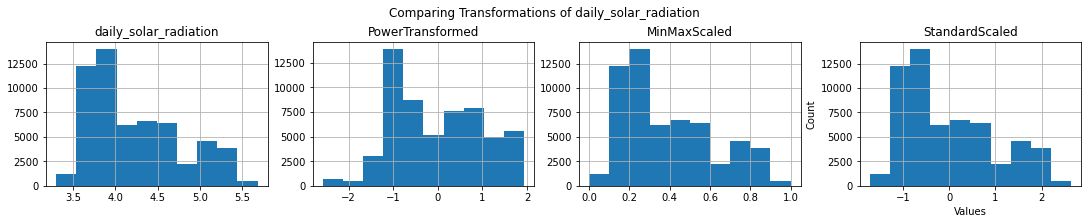

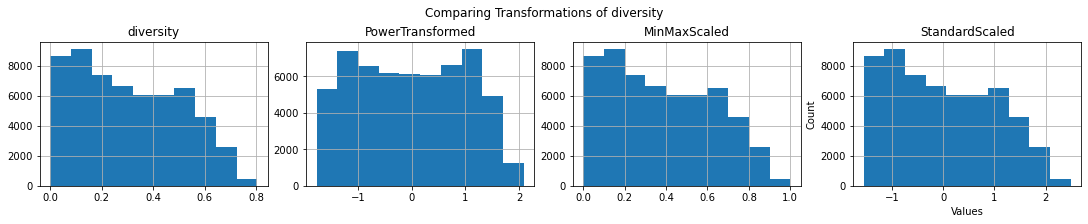

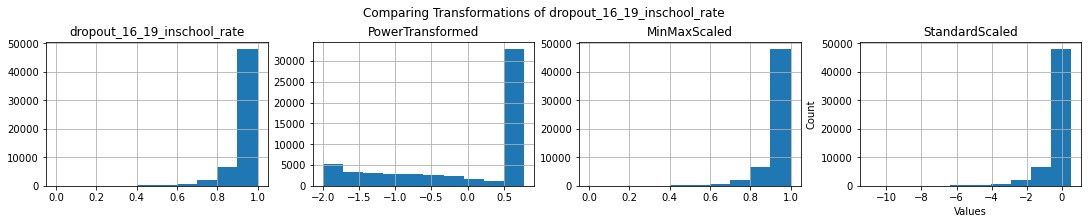

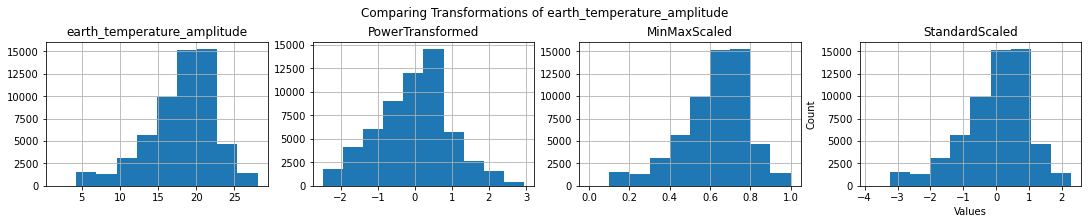

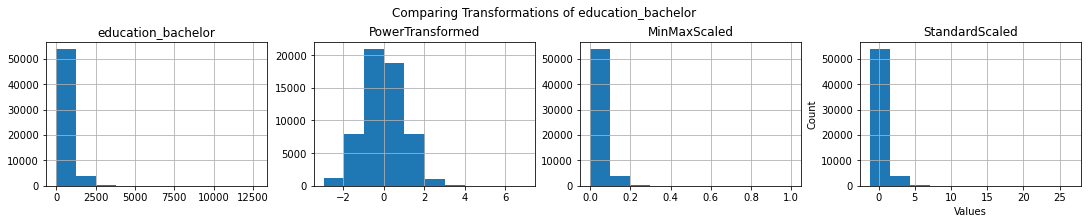

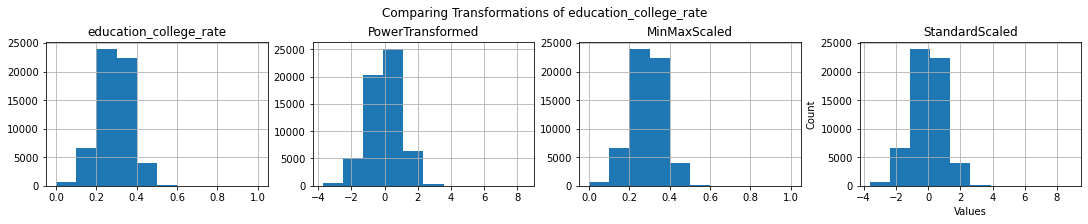

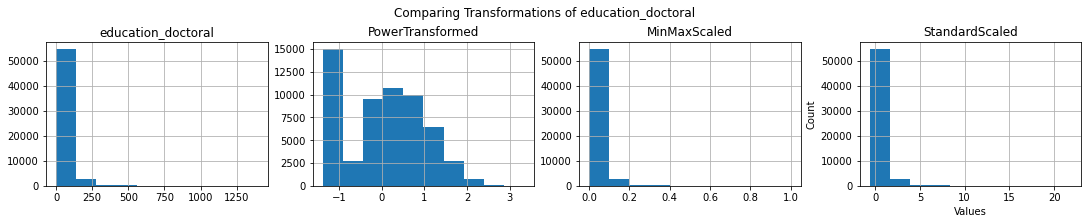

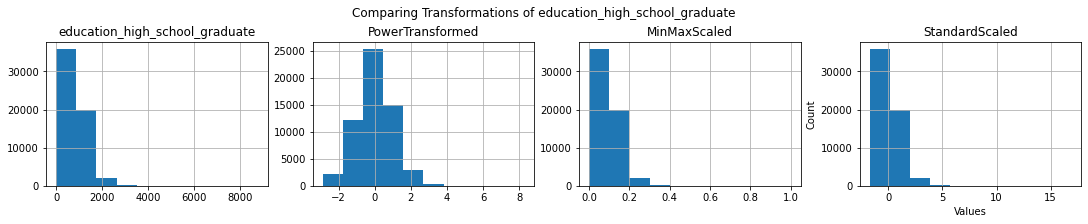

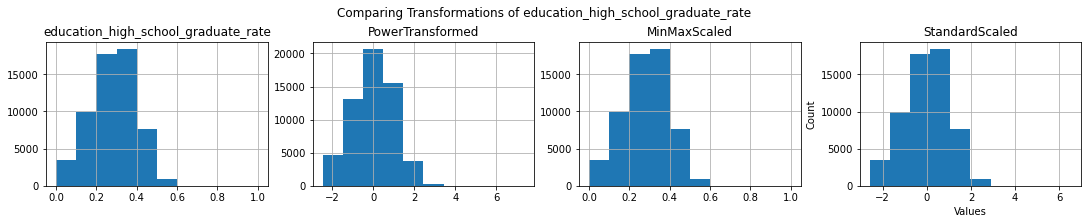

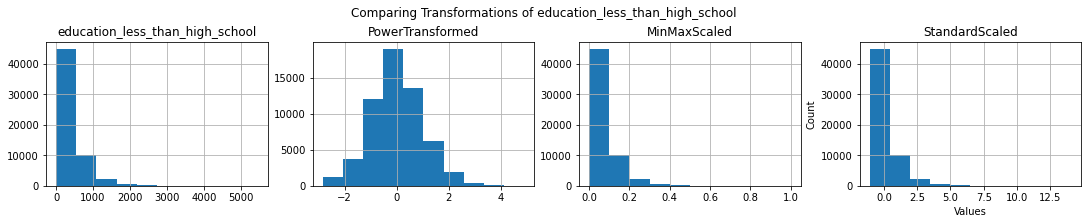

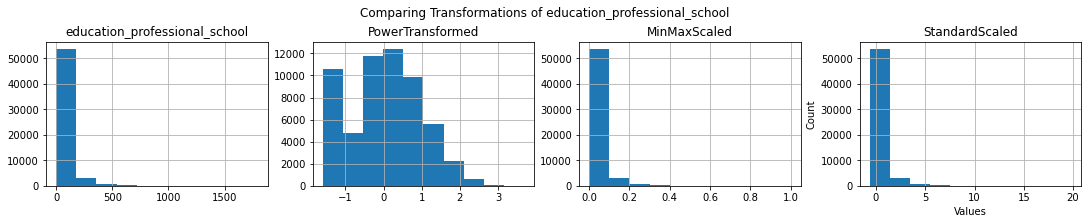

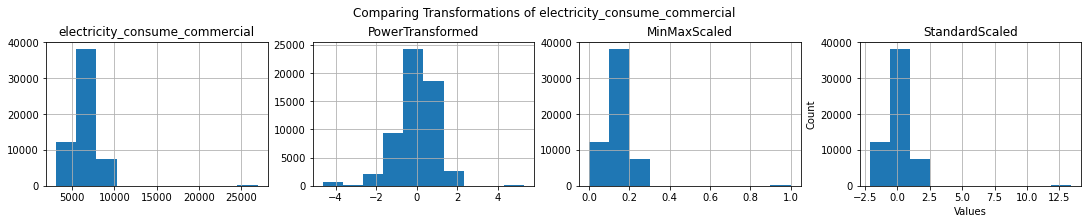

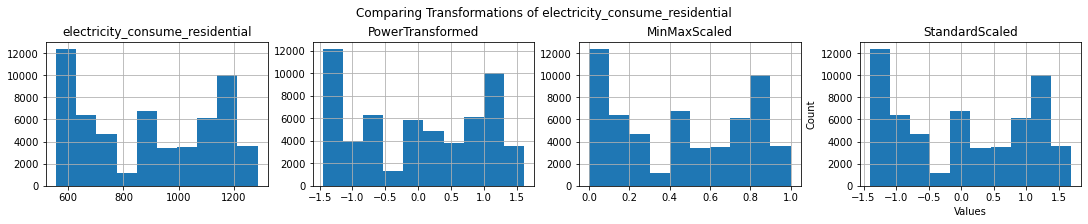

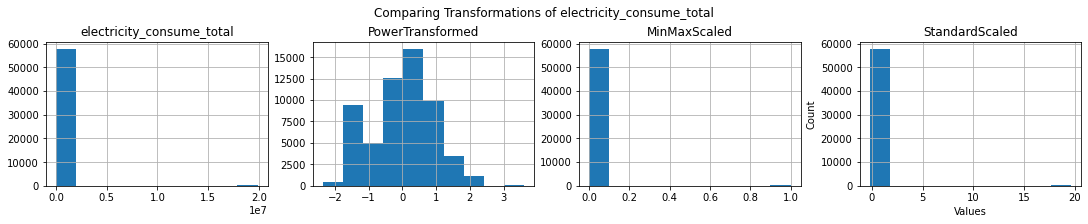

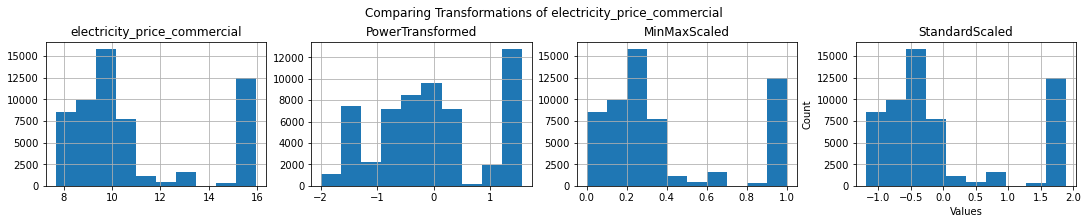

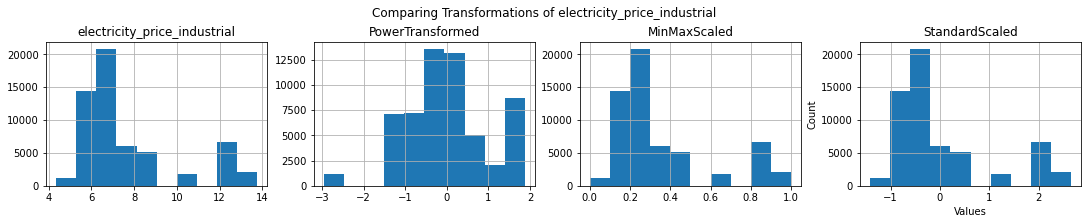

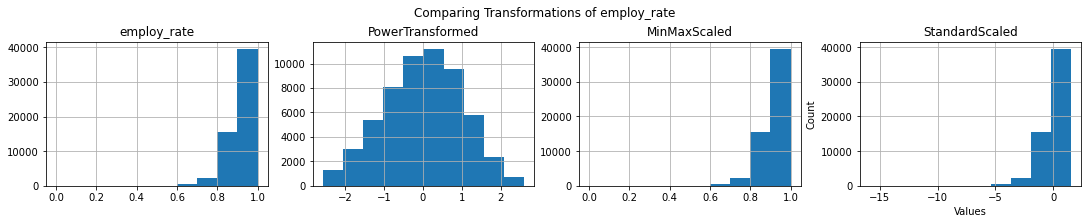

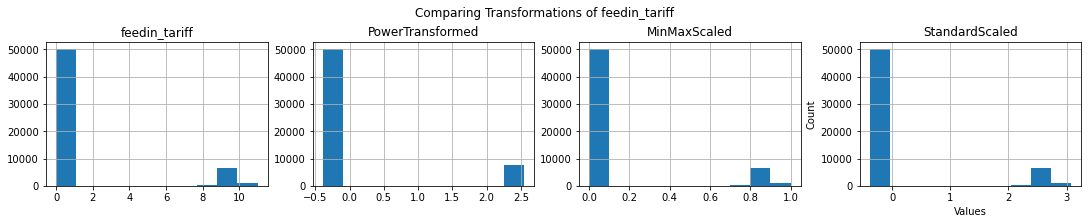

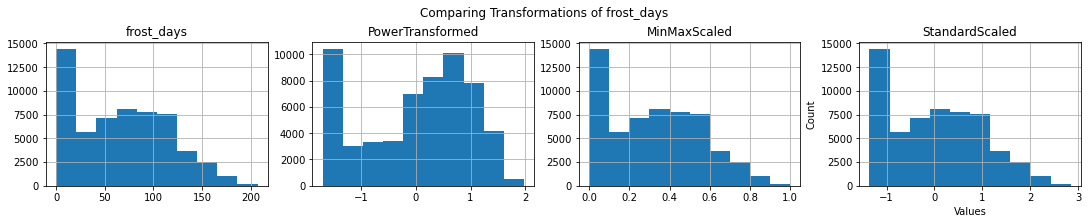

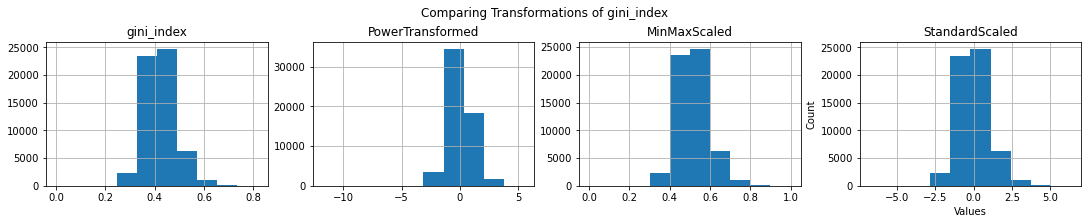

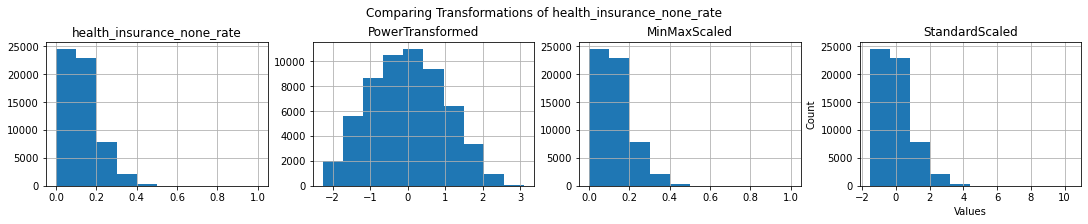

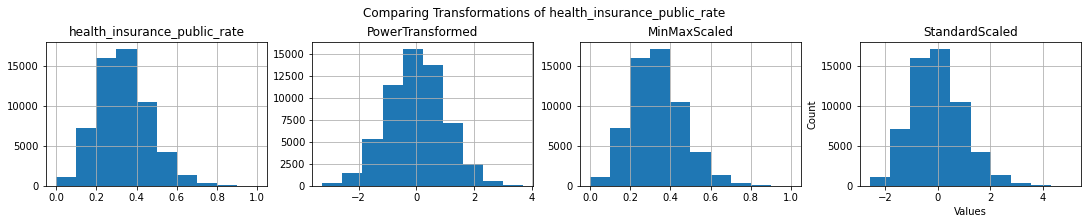

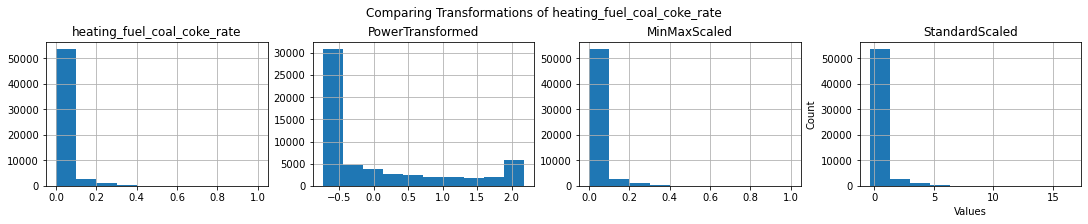

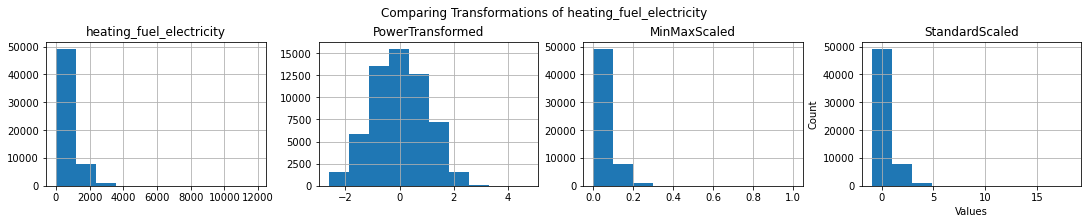

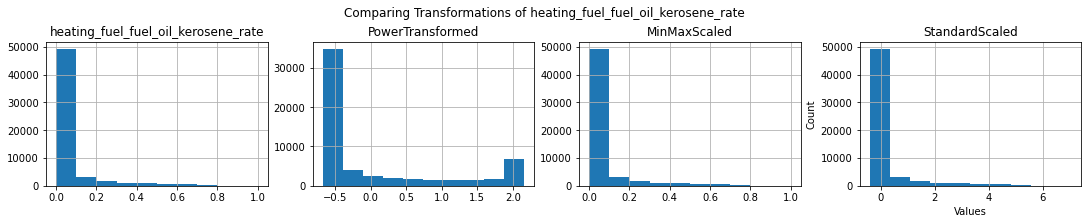

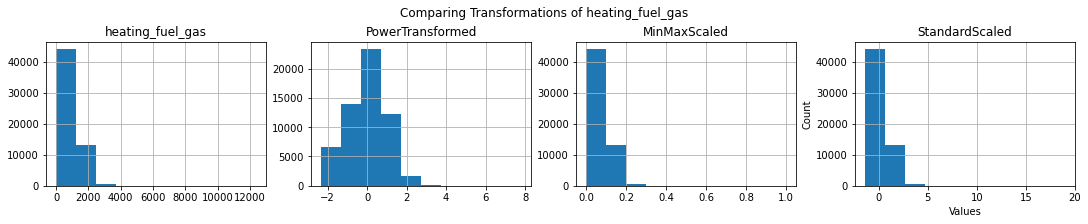

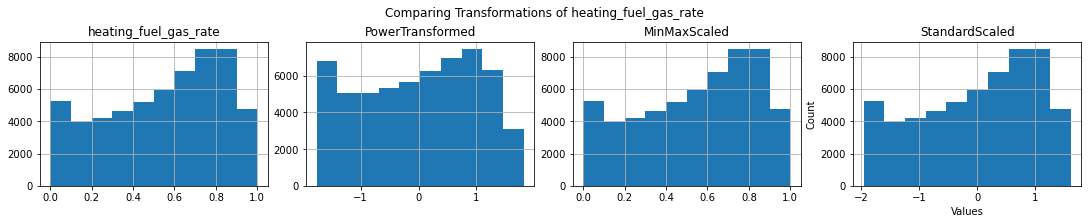

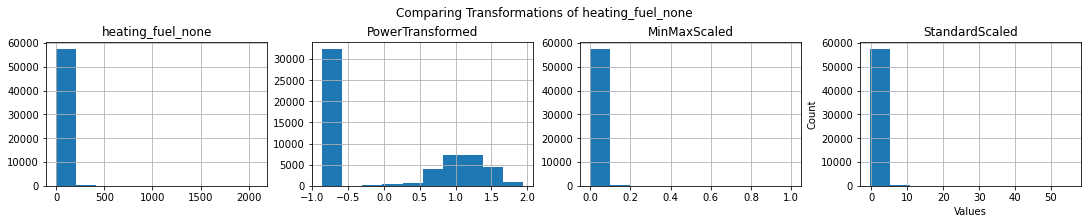

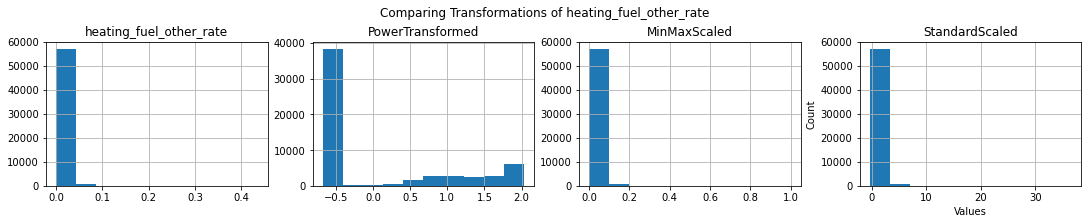

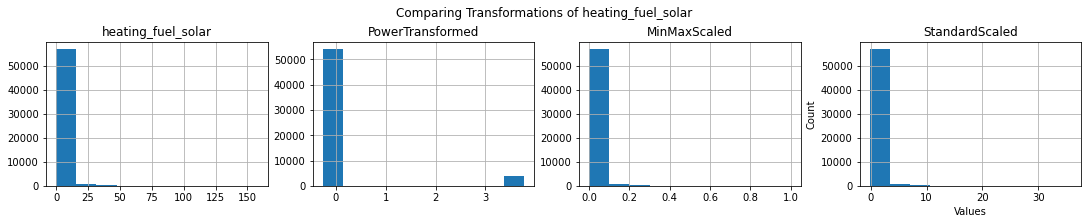

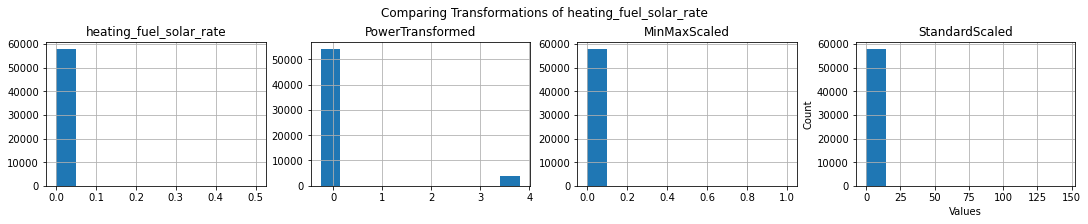

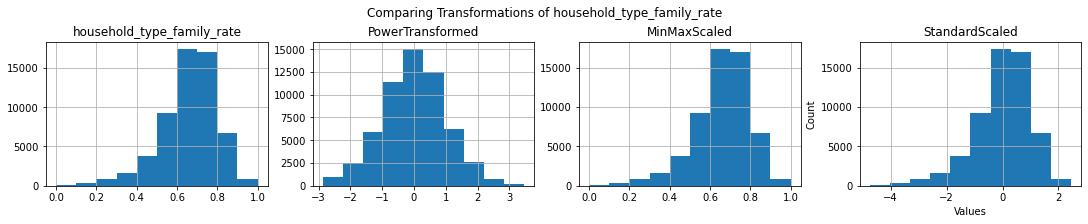

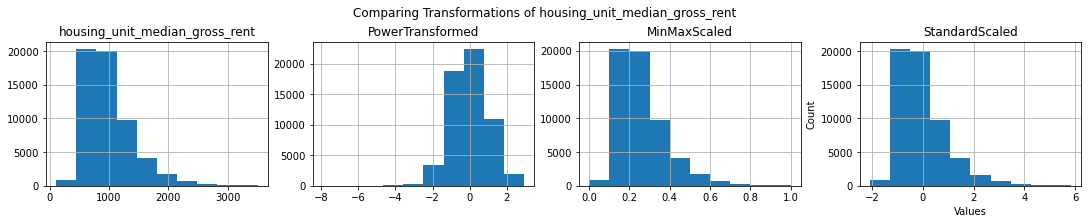

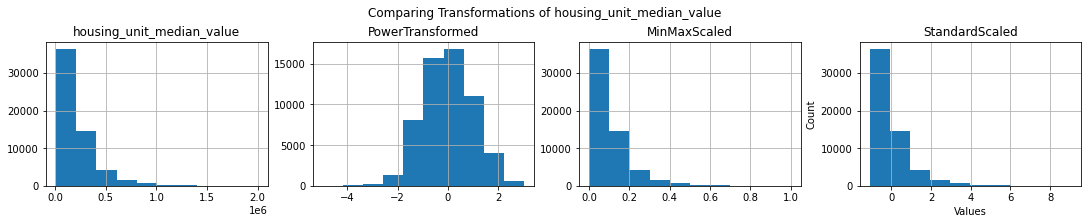

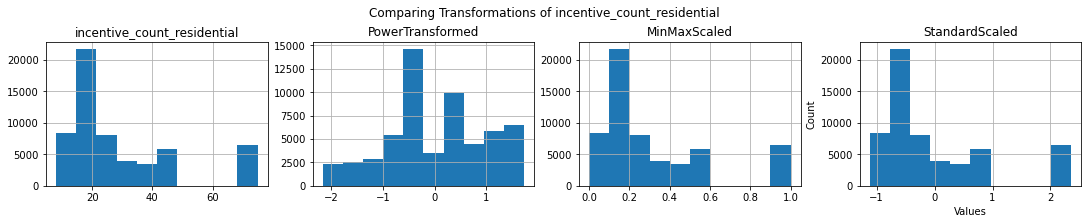

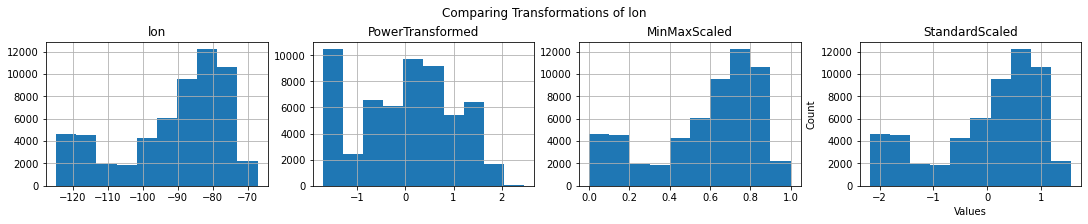

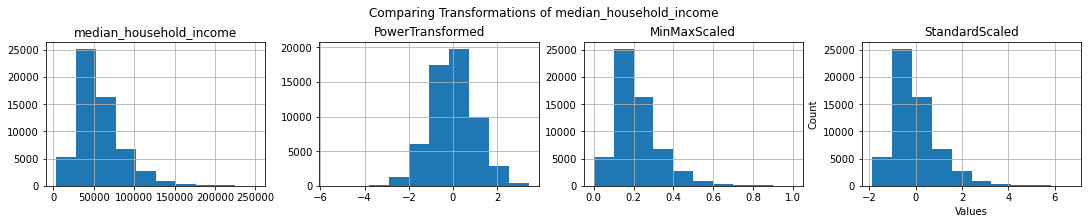

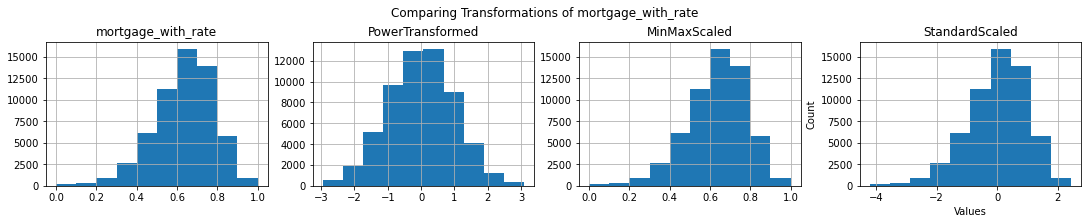

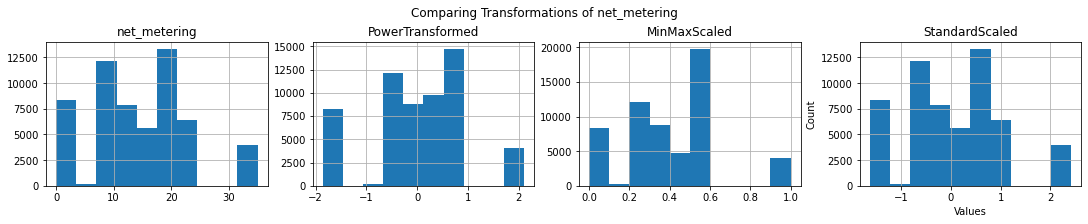

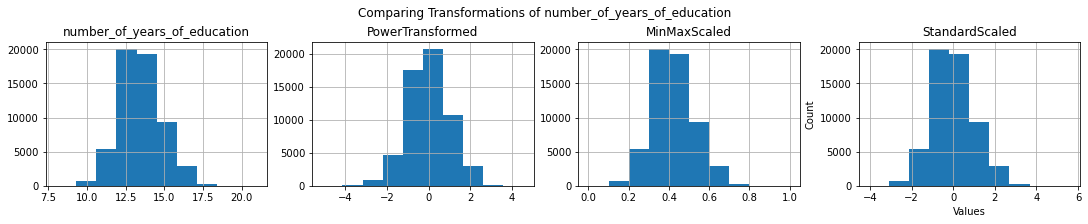

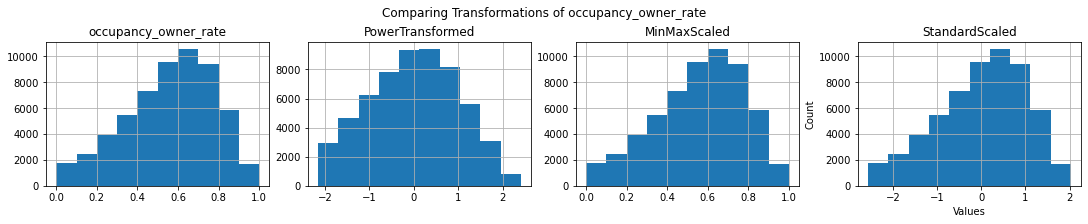

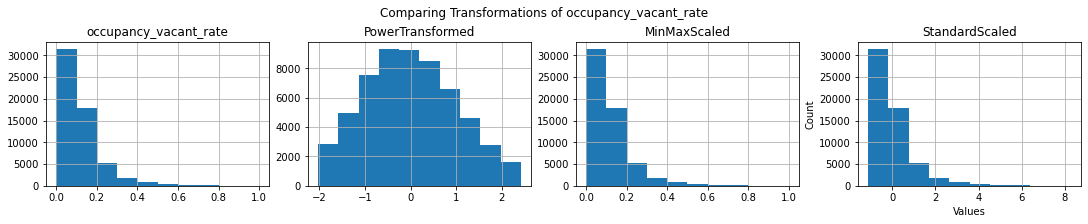

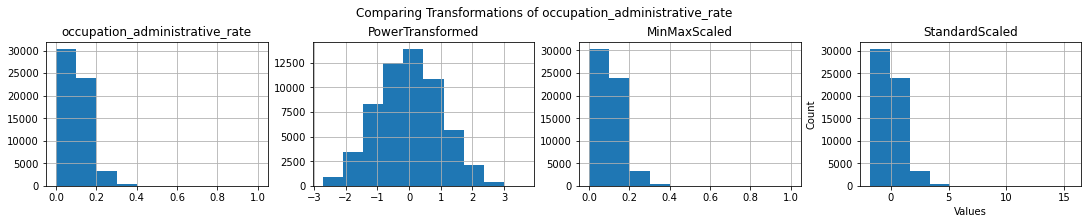

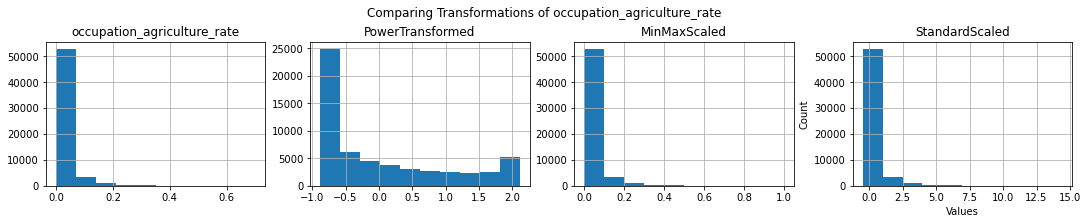

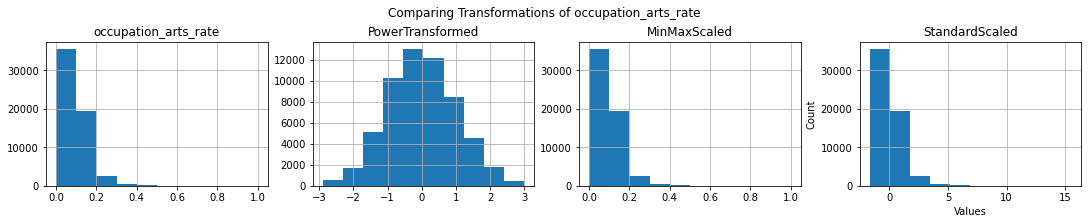

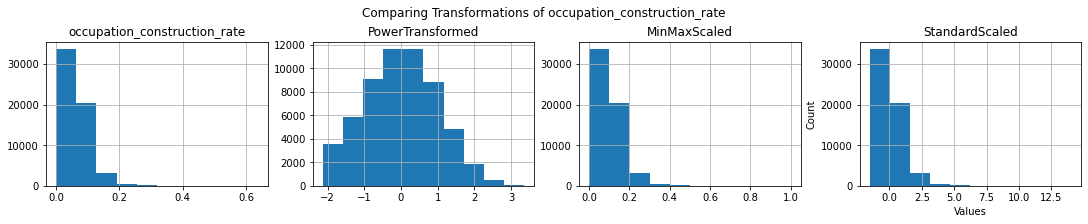

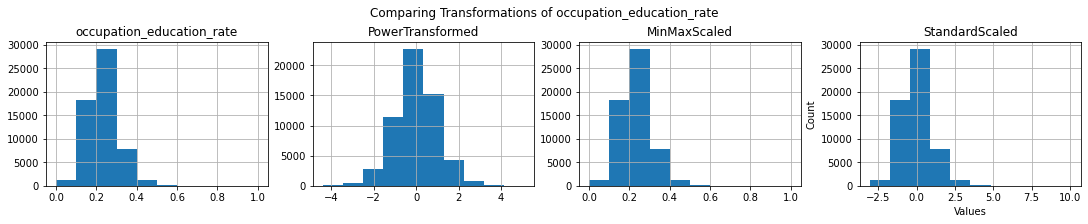

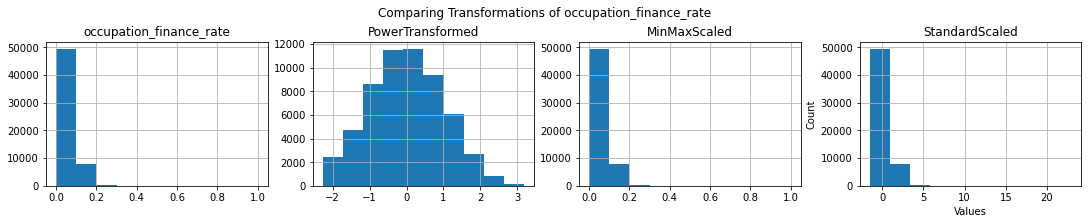

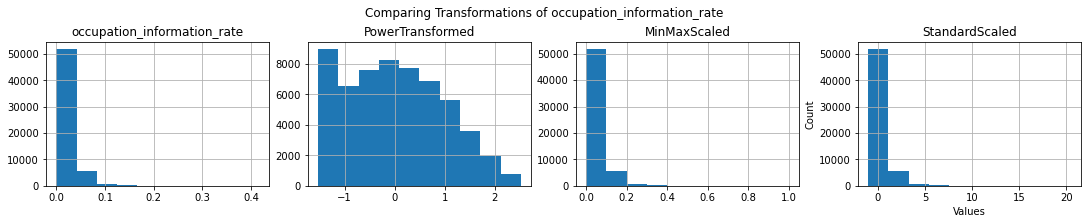

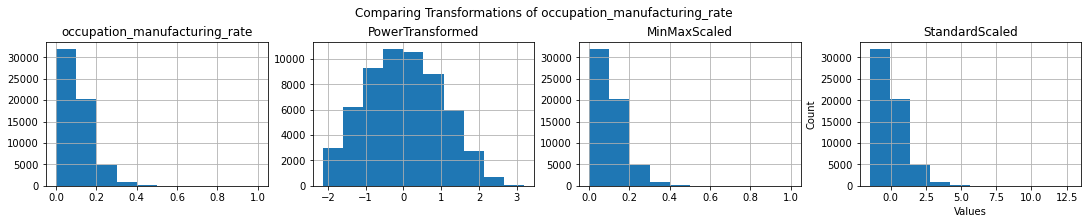

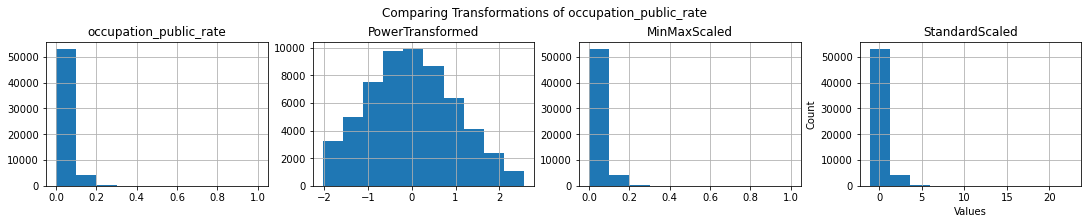

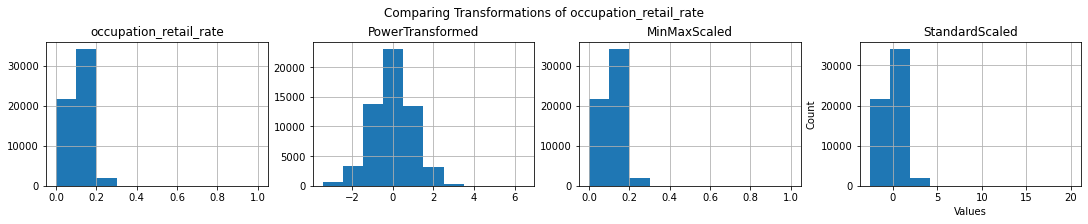

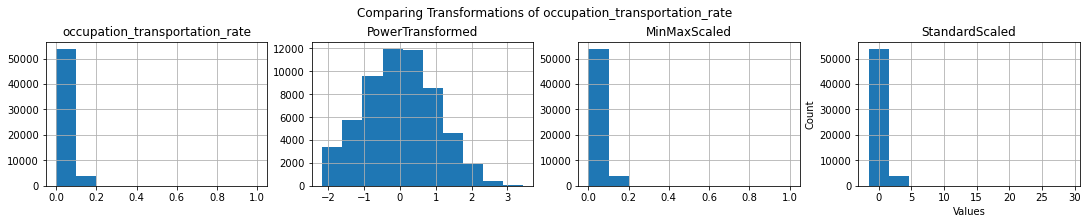

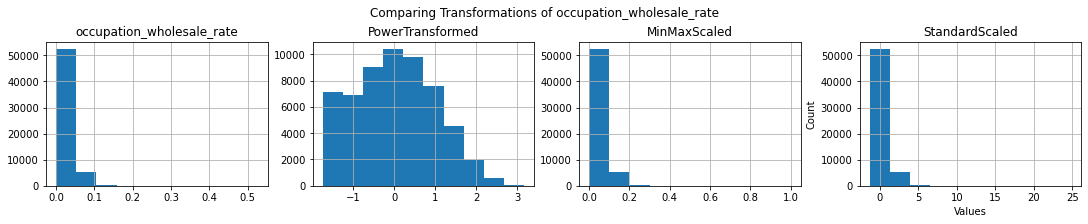

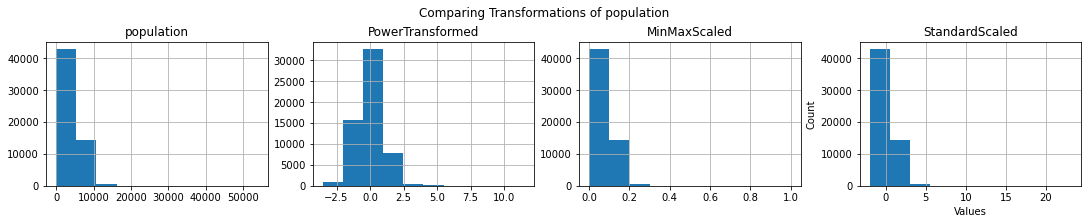

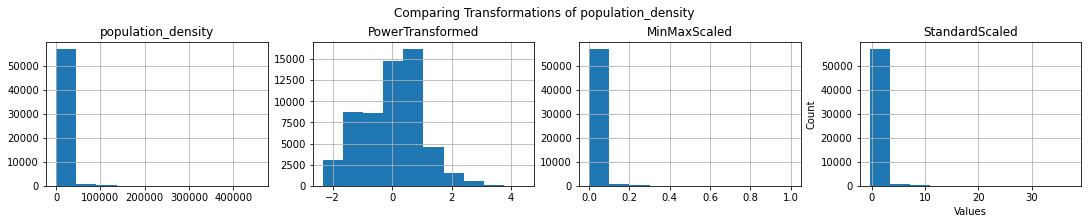

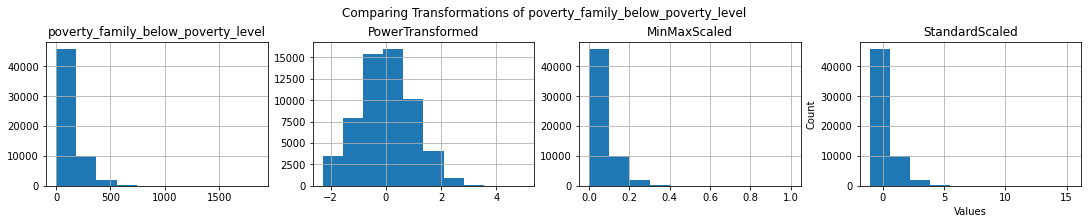

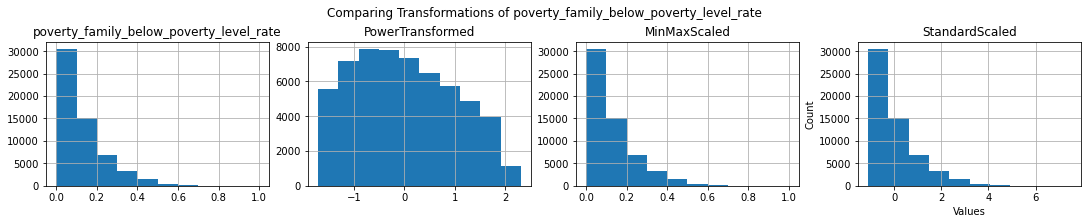

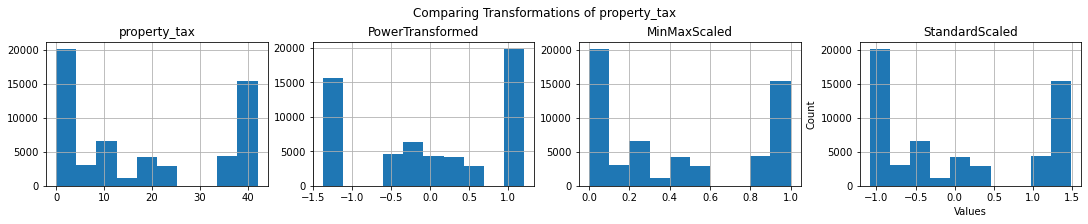

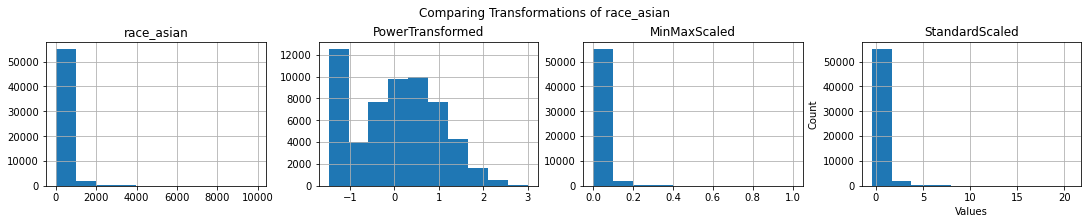

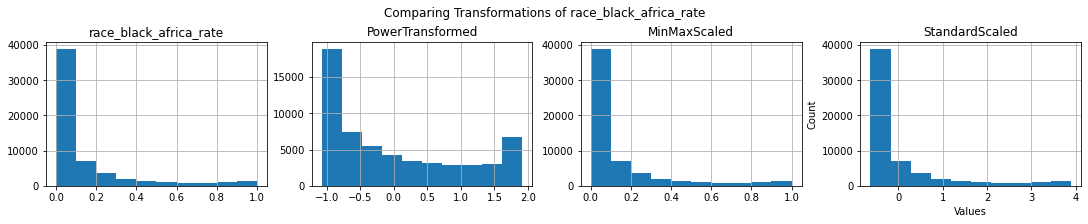

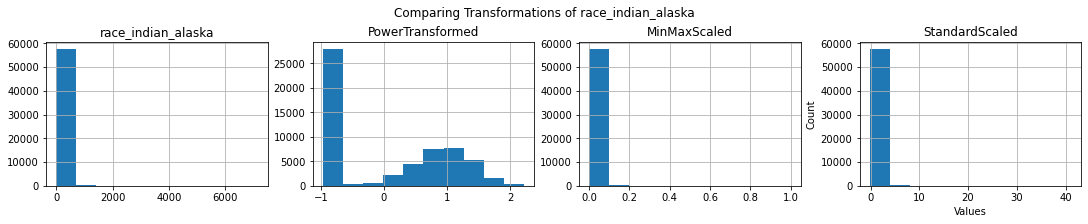

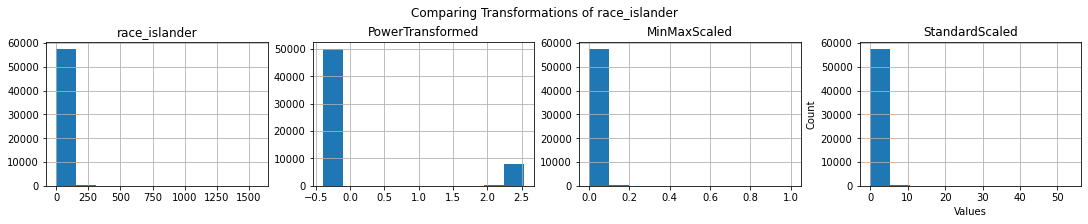

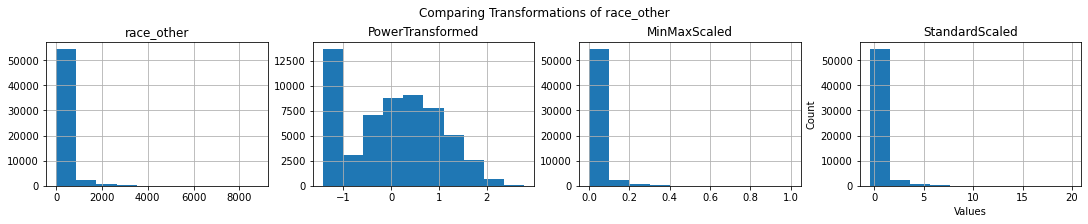

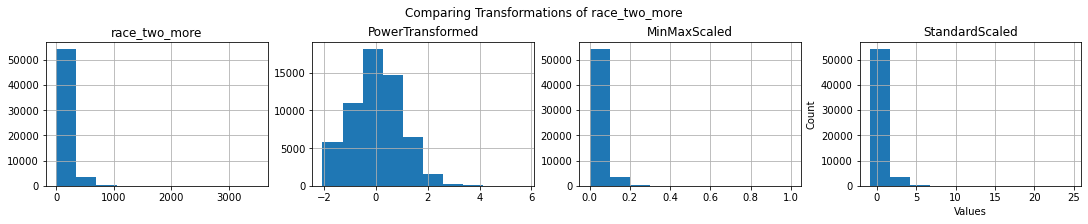

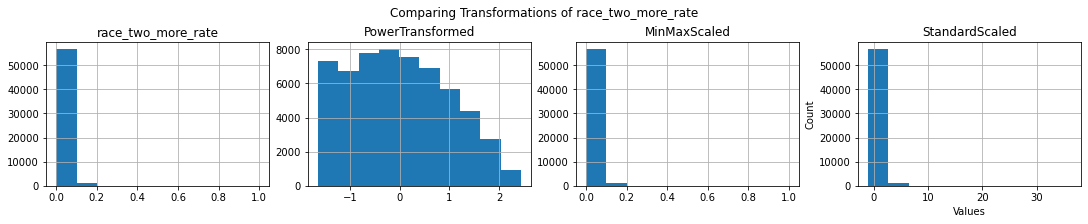

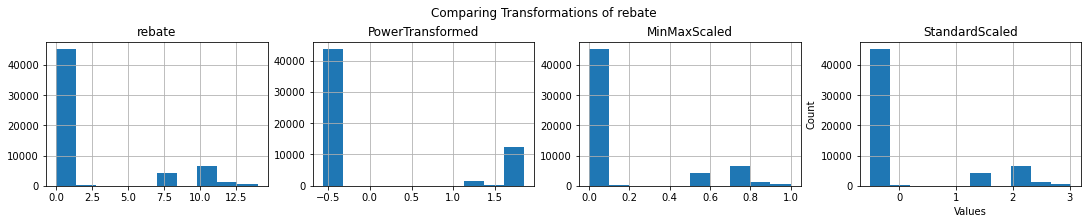

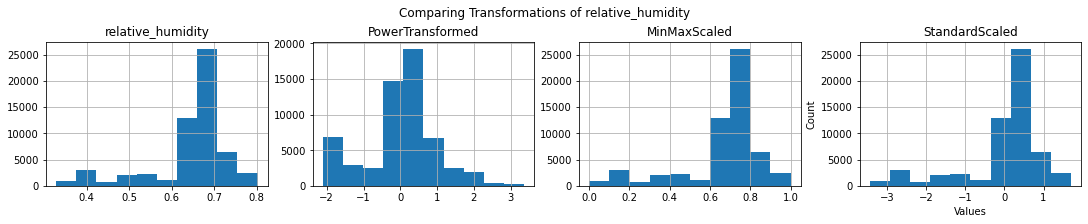

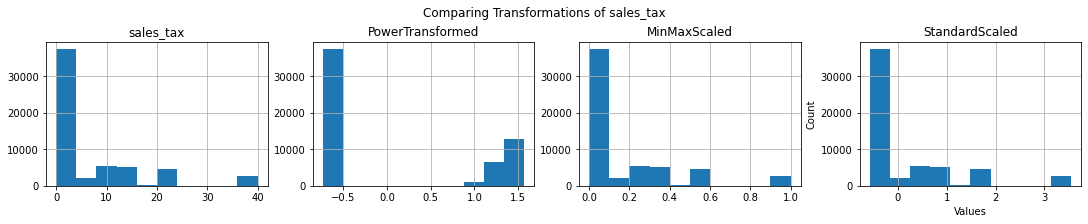

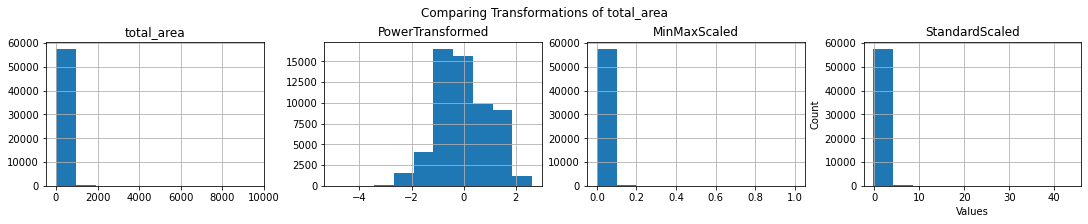

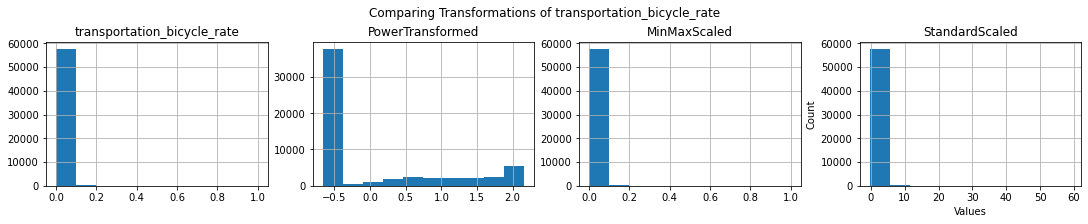

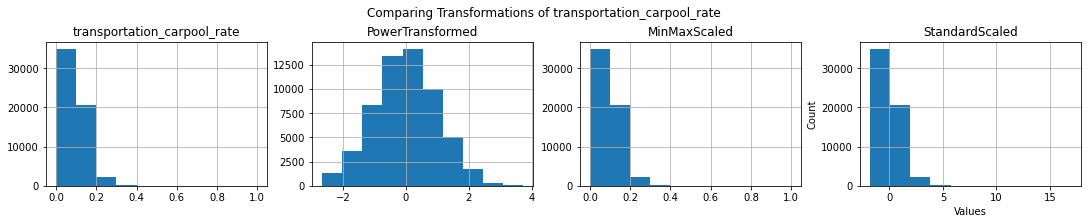

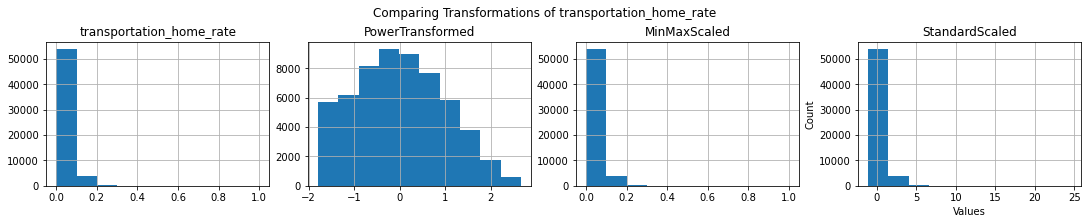

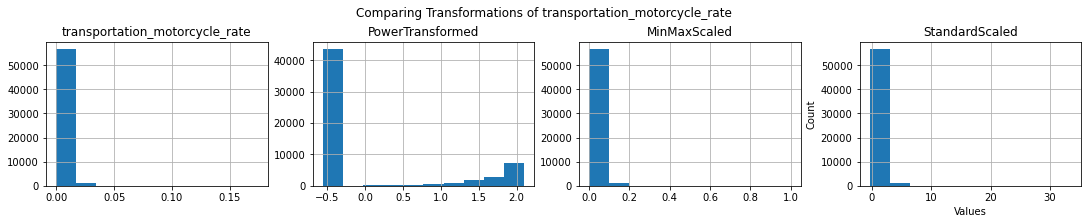

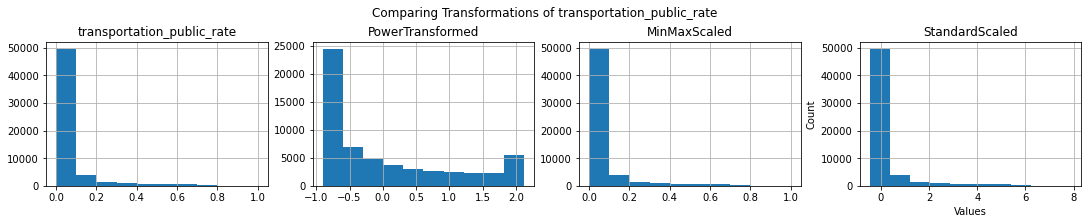

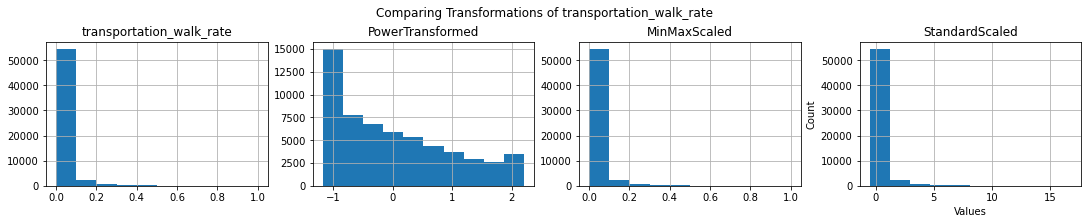

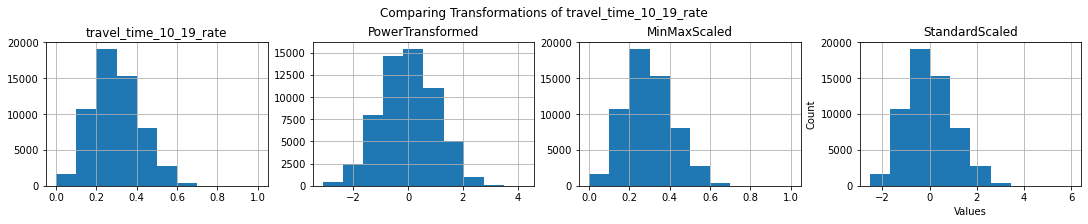

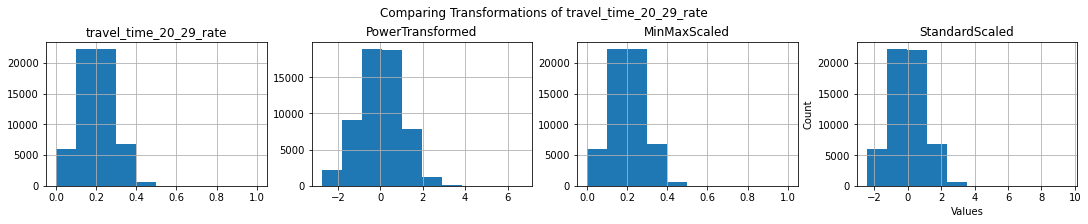

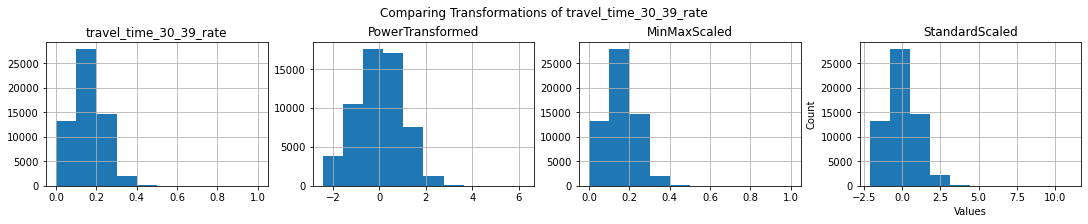

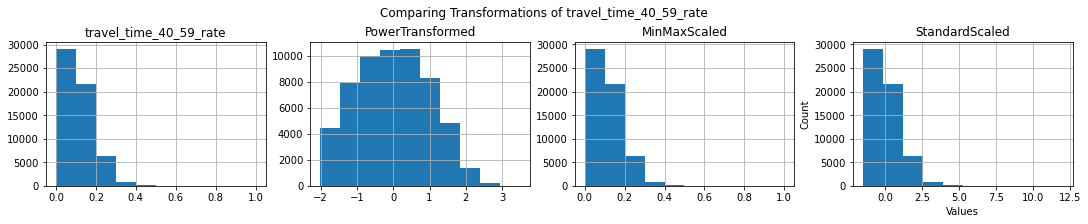

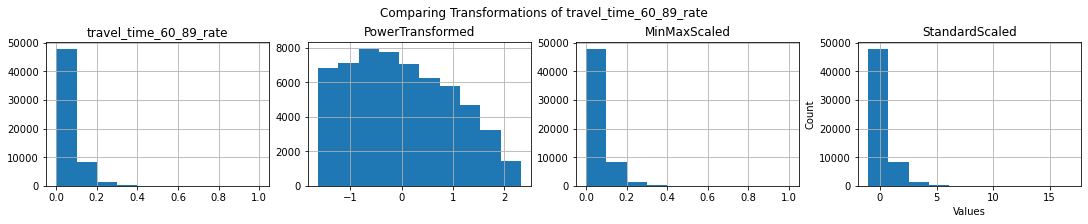

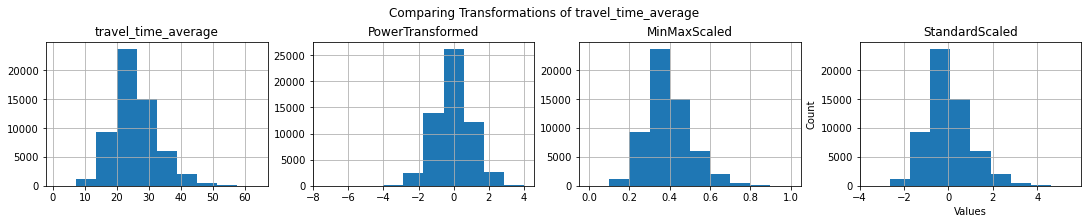

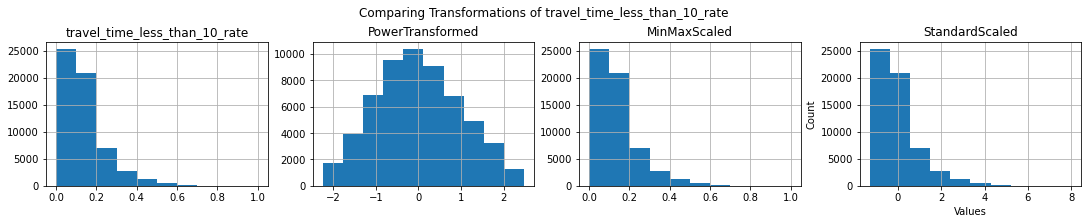

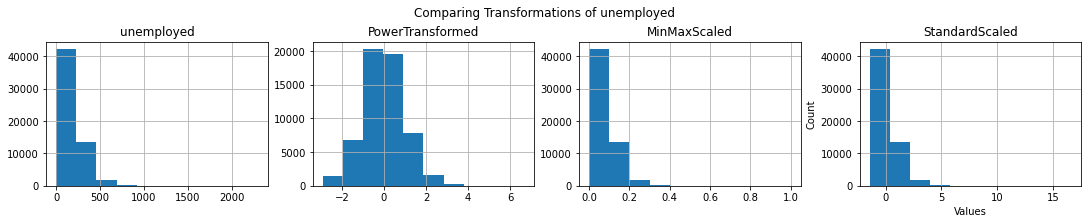

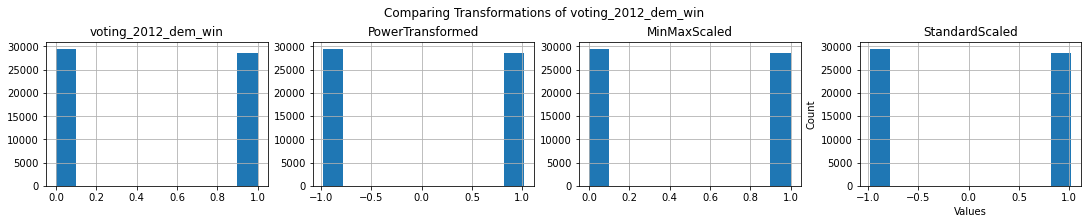

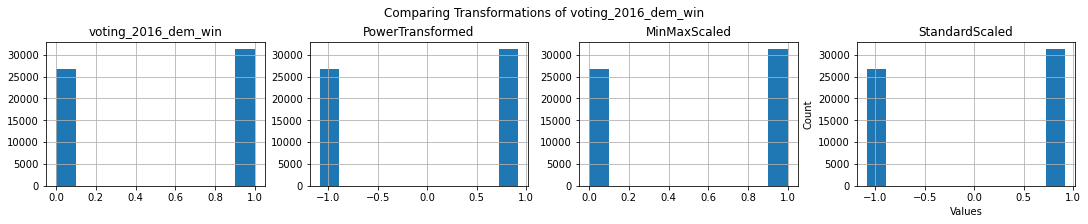

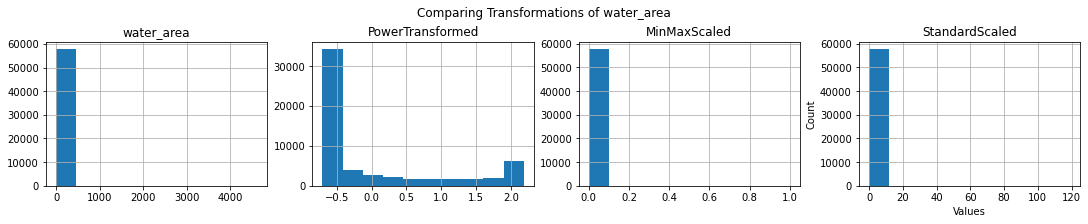

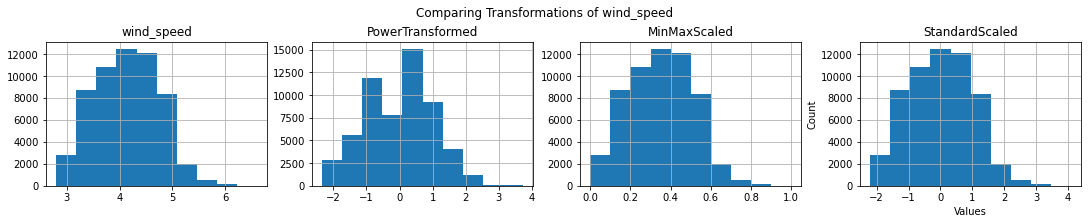

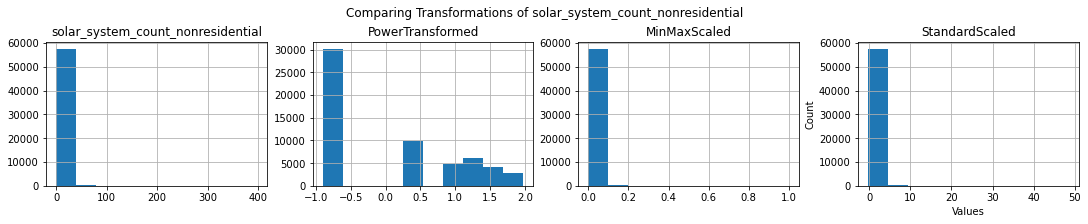

In [26]:
#Investigate distribution of values for numeric columns - determine type of transformation to fix scewness and 
#scale discrepencies in the data
no_plot = list()
for col in list(train_data.select_dtypes(include=[np.number]).columns.values):
    try:
        transformation_comparison(train_data, col)
    except:
        no_plot.append(col)
        continue

In [27]:
no_plot

[]

From the distributions above, the log transformation does the best job of making the distributions more Gaussian. Will apply this transformation to all of the data.

In [29]:
train_data = train_data.drop(['PowerTransformed', 'MinMaxScaled', 'StandardScaled'], axis=1)

In [30]:
#Use Box-Cox transformation on strictly positive variables and Yeo-Johnson on other columns
numeric_cols = list(train_data.select_dtypes(include=[np.number]).columns.values)
pos_cols = [col for col in numeric_cols if train_data[col].min() > 0 and test_data[col].min() > 0 and col not in no_plot]
nonpos_cols = [col for col in numeric_cols if col not in pos_cols and col not in no_plot and col != target_var]

#Use box-cox method to transform positive columns
pt = PowerTransformer('box-cox')
print(pt.fit(train_data[pos_cols]))
train_data[pos_cols] = pt.transform(train_data[pos_cols])
test_data[pos_cols] = pt.transform(test_data[pos_cols])

#Use yeo-johnson method to transform columns with negative values
pt2 = PowerTransformer('yeo-johnson')
print(pt2.fit(train_data[nonpos_cols]))
train_data[nonpos_cols] = pt2.transform(train_data[nonpos_cols])
test_data[nonpos_cols] = pt2.transform(test_data[nonpos_cols])

PowerTransformer(method='box-cox')
PowerTransformer()


In [31]:
#Split data into data and labels for model training
target_var = 'solar_system_count_nonresidential'
train_labels = train_data[target_var]
train_data = train_data[train_data.columns.difference([target_var])]
test_labels = test_data[target_var]
test_data = test_data[test_data.columns.difference([target_var])]

# Model Creation

## XGBoost Model

### Default Model

In [32]:
# XGB parameters (extreme gradient boosting)
params_xgb = {
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'learning_rate': 0.01
             }

In [33]:
#Setup the model
model = XGBRegressor(**params_xgb)

In [41]:
#Fit the model and record time
%%time
model.fit(train_data, train_labels)

CPU times: user 25min 14s, sys: 6.89 s, total: 25min 21s
Wall time: 3min 22s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

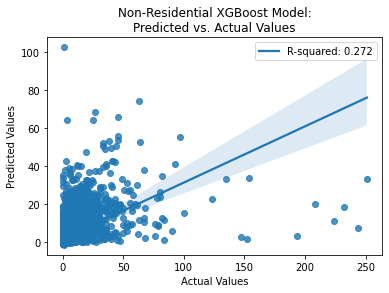

<Figure size 432x288 with 0 Axes>

In [42]:
#Output scatterplot of predicted vs. actual values
test_predictions = model.predict(test_data)
regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Non-Residential XGBoost Model:\nPredicted vs. Actual Values',
                   '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/xgboost_nonresidential_system_count_errors_default')

In [ ]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Non-Residential XGBoost Model:\nPrediction Error')
# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_errors_hist.png")

In [44]:
#Retrieve MSE score for the model
mse = round(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 47


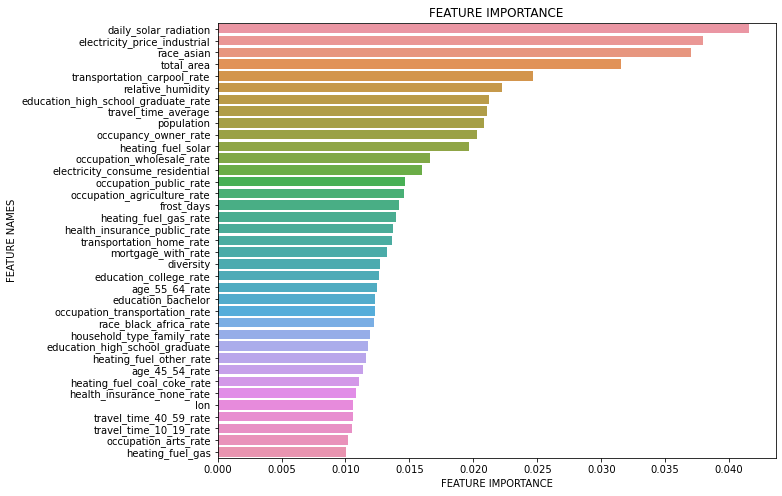

In [45]:
#Plot feature importances for model
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_feature_importance.png")

In [51]:
#Save model
# pickle.dump(model, open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_nonresidential_solar_system_count.sav', 'wb'))


In [68]:
#load saved model
#loaded_model = pickle.load(open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential.sav', 'rb'))
# plot_feature_importance(loaded_model.feature_importances_, train_data.columns)

### Tuned Model

In [46]:
model = XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [.01, 0.1], 
              'max_depth': [7,10,20],
              'min_child_weight': [1, 10 ,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,500,600, 1000],
              "reg_alpha"   : [0, 0.5,0.2,1],
              "reg_lambda"  : [0, 2,3,5],
              "gamma"       : [0, 1 ,3]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                                           n_iter=100, cv=5, verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = 'neg_mean_absolute_error')
random_search.fit(train_data, train_labels)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.311 total time= 8.9min
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.178 total time=11.3min
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.281 total time= 9.4min
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-2.346 total time=12.7min
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, g

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.432 total time=41.4min
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=500, objective=reg:squarederror, reg_alpha=0, reg_lambda=5;, score=-2.178 total time=47.0min
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.369 total time= 8.9min
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.318 total time=10.6min
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=25, n_estimat

[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=0;, score=-2.418 total time=53.2min
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=1000, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-2.403 total time=57.9min
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0, reg_lambda=3;, score=-2.459 total time=44.7min
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=500, objective=reg:squarederror, reg_alpha=1, reg_lambda=5;, score=-2.046 total time=58.7min
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estima

[01:59:09] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END booster=gblinear, colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-2.868 total time=  50.1s
[01:59:58] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please op

[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=0;, score=-2.203 total time= 5.4min
[01:53:54] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 4/5] END booster=gblinear, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=0, reg_lambda=5;, score=-2.968 total time=  44.6s
[CV 1/5] END booster=gbtree, colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=500, objective=reg:sq

[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=0;, score=-2.230 total time=54.3min
[23:09:08] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-2.957 total time=  21.2s
[23:09:30] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This

[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-2.220 total time= 6.9min
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=10, n_estimators=1000, objective=reg:squarederror, reg_alpha=0, reg_lambda=0;, score=-2.266 total time=27.9min
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=0;, score=-2.245 total time=12.6min
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0, reg_lambda=3;, score=-2.355 total time=35.8min
[00:42:07] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" }

[CV 5/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=3;, score=-2.292 total time=17.8min
[04:06:17] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 5/5] END booster=gblinear, colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=500, objective=reg:squarederror, reg_alpha=1, reg_lambda=3;, score=-3.236 total time=  23.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=25, n_estimators=500, objective=reg:squar

[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=3;, score=-2.264 total time=21.8min
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, gamma=3, learning_rate=0.01, max_depth=20, min_child_weight=25, n_estimators=500, objective=reg:squarederror, reg_alpha=1, reg_lambda=3;, score=-2.210 total time=42.8min
[04:46:21] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5] END booster=gblinear, colsample_bytree=0.9, gamma=1, learning_rate=0.01, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:s

KeyboardInterrupt: 

In [ ]:
random_search.best_params_

In [47]:
#Run XGBoost model with tuned hyperparameters
params_xgb = {'reg_lambda': 3,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 20,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.8,
 'booster': 'gbtree'}
model = XGBRegressor(**params_xgb)

In [48]:
%%time
model.fit(train_data, train_labels)

CPU times: user 22min 54s, sys: 13.2 s, total: 23min 7s
Wall time: 3min 13s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=3, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

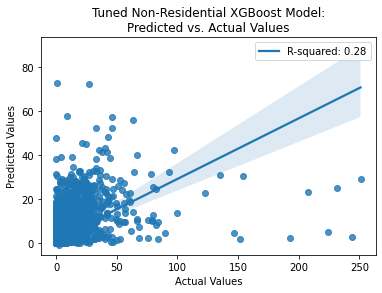

<Figure size 432x288 with 0 Axes>

In [49]:
test_predictions = model.predict(test_data)

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Tuned Non-Residential XGBoost Model:\nPredicted vs. Actual Values',
                   "/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_errors_tuned")

In [50]:
mse = round(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 47


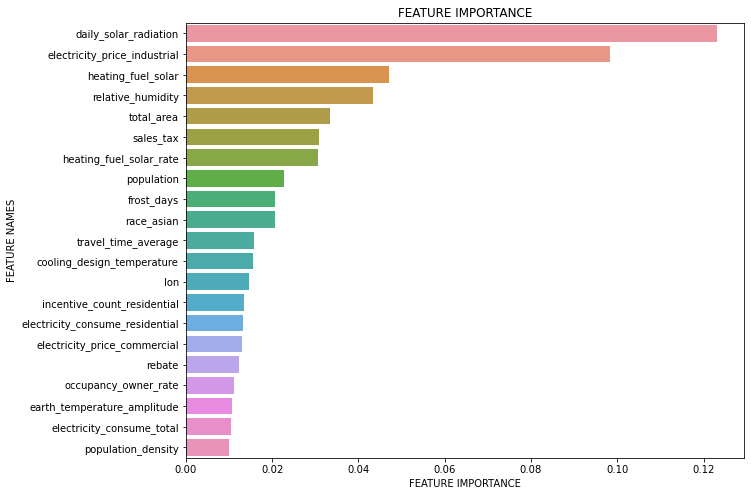

In [51]:
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_feature_importance.png")

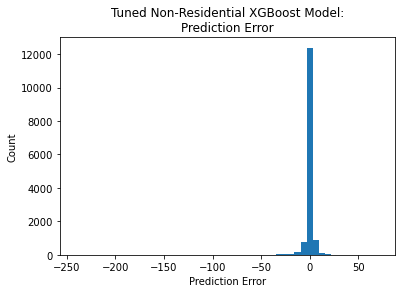

In [52]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Tuned Non-Residential XGBoost Model:\nPrediction Error')
# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_errors_hist.png")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


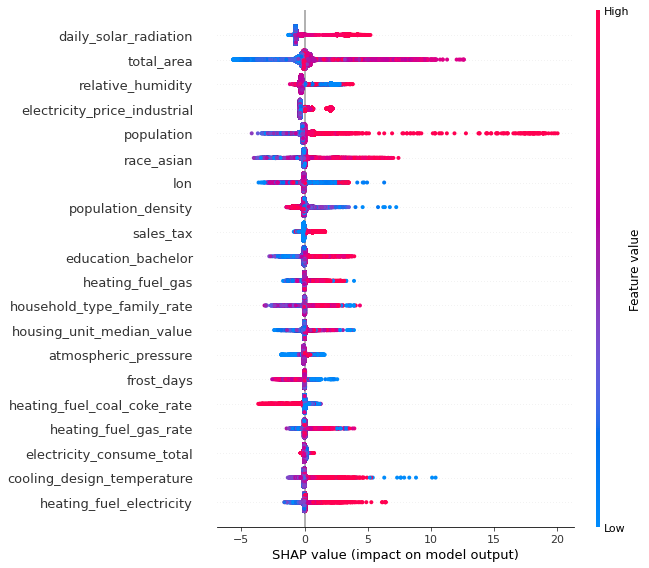

<Figure size 432x288 with 0 Axes>

In [54]:
#Examine Shapley values as another form of feature importance evaluation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data, approximate=True)
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_shap.png")

## Random Forest Model

### Default Model

In [55]:
# RFR parameters (random forest regression)
params_rfr = {'n_estimators': 1000,
 'criterion': 'squared_error',
             }
model = RandomForestRegressor(**params_rfr)

In [56]:
%%time
model.fit(train_data, train_labels)


CPU times: user 1h 39min 16s, sys: 1min 5s, total: 1h 40min 22s
Wall time: 1h 43min 55s


RandomForestRegressor(n_estimators=1000)

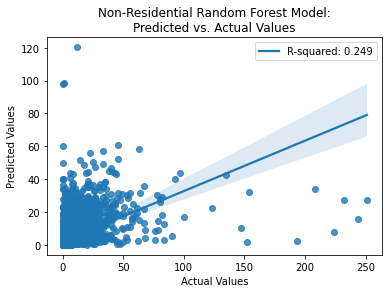

<Figure size 432x288 with 0 Axes>

In [57]:
test_predictions = model.predict(test_data)

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Non-Residential Random Forest Model:\nPredicted vs. Actual Values',
                   '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/rf_nonresidential_system_count_errors_default')


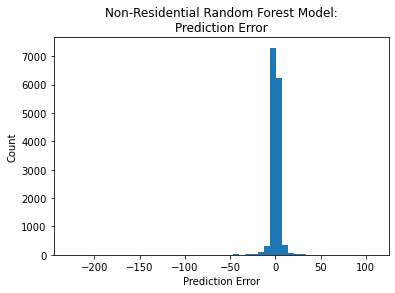

In [58]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Non-Residential Random Forest Model:\nPrediction Error')

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_errors_hist.png")

In [59]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 49.573438197007306


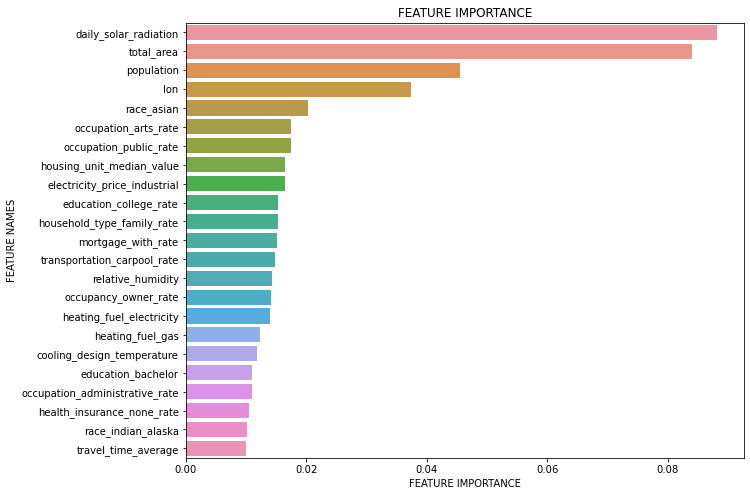

In [60]:
fi_rf = plot_feature_importance(model.feature_importances_, train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_feature_importance.png")

### Tuned Model

In [106]:
model = RandomForestRegressor()

parameters = {'criterion':['squared_error'],
              'n_estimators': [300,500,600, 1000],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [7,10,20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
              'bootstrap': [True, False]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                                           n_iter=50, cv=5, verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = 'neg_mean_absolute_error')
random_search.fit(train_data, train_labels)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 3/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-2.426 total time=51.5min
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-2.384 total time= 3.5min
[CV 3/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=-2.384 total time=40.6min
[CV 2/5] END bootstrap=False, criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1000;, score=-2.214 total time=14.5min
[CV 1/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-2.505 total time=39.8min
[CV 4/5] END bootstrap=True, criterio

[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=-2.446 total time=12.4min
[CV 5/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=-2.389 total time=11.9min
[CV 3/5] END bootstrap=False, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=600;, score=-2.457 total time=35.9min
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=-2.291 total time=27.5min
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=-2.393 total time=29.2min
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2

[CV 4/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-2.584 total time=50.9min
[CV 5/5] END bootstrap=False, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=600;, score=-2.462 total time=35.0min
[CV 3/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=-2.199 total time=29.7min
[CV 5/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-2.446 total time=39.6min
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=1000;, score=-2.290 total time= 8.8min
[CV 5/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=sqrt, min_sample

[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=-2.373 total time=12.4min
[CV 1/5] END bootstrap=False, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=600;, score=-2.482 total time=36.2min
[CV 4/5] END bootstrap=False, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=600;, score=-2.565 total time=34.7min
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=-2.379 total time=29.8min
[CV 3/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-2.415 total time=39.9min
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_lea

[CV 3/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=-2.333 total time=12.4min
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=-2.465 total time=11.8min
[CV 2/5] END bootstrap=False, criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=600;, score=-2.552 total time=35.6min
[CV 5/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=-2.489 total time=41.2min
[CV 4/5] END bootstrap=False, criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1000;, score=-2.244 total time=13.9min
[CV 4/5] END bootstrap=False, criterion=squared_error, max_depth=10, max_features=auto, min_samples_lea

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error'],
                                        'max_depth': [7, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 500, 600, 1000]},
                   random_state=111, scoring='neg_mean_absolute_error',
                   verbose=3)

In [108]:
random_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'squared_error',
 'bootstrap': False}

In [109]:
 params_rfr = {'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'squared_error',
 'bootstrap': False}
model = RandomForestRegressor(**params_rfr)

In [110]:
%%time
model.fit(train_data, train_labels)

CPU times: user 9min 20s, sys: 1.12 s, total: 9min 21s
Wall time: 9min 22s


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=5,
                      n_estimators=1000)

In [111]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 50.3122970717569


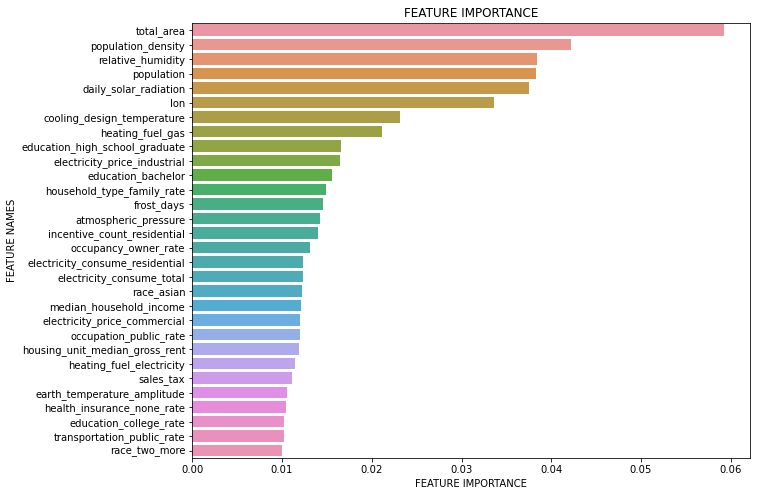

In [112]:
fi_rf = plot_feature_importance(model.feature_importances_, train_data.columns)

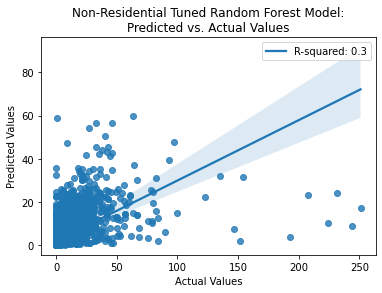

<Figure size 432x288 with 0 Axes>

In [113]:
test_predictions = model.predict(test_data)

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Non-Residential Tuned Random Forest Model:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/rf_nonresidential_system_count_errors_tuned')


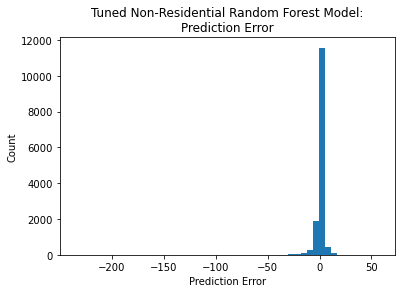

In [114]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Tuned Non-Residential Random Forest Model:\nPrediction Error')

# Neural Network Regression

### Single Layer Neural Network

In [61]:
# Define basic architecture - code from Pierre Gentine - ML for Environmental Engineering
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define optimizer
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 13,441
Trainable params: 13,441
Non-trainable params: 0
_________________________________________________________________


2021-12-21 09:40:06.080282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-12-21 09:40:49.833156: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



................................

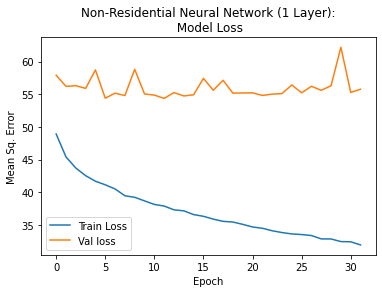

In [63]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history, 'Non-Residential Neural Network (1 Layer):\n Model Loss')

In [64]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      51


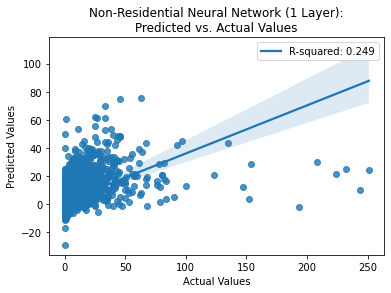

<Figure size 432x288 with 0 Axes>

In [65]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Non-Residential Neural Network (1 Layer):\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/nn_nonresidential_system_count_errors_1L')


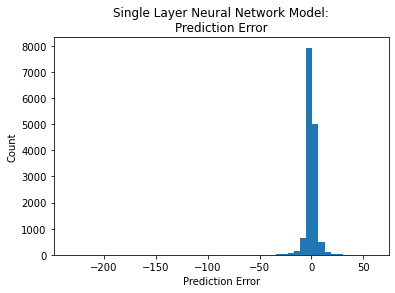

In [66]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Single Layer Neural Network Model:\nPrediction Error')

### 3 Layer Neural Network

In [119]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



........................................

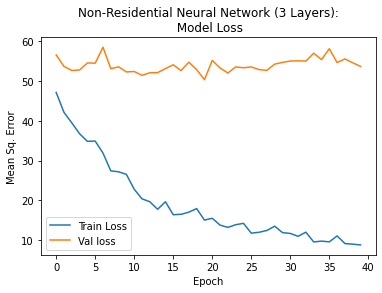

In [120]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history, 'Non-Residential Neural Network (3 Layers):\n Model Loss')

In [121]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      53


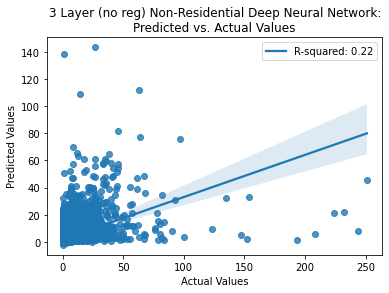

<Figure size 432x288 with 0 Axes>

In [122]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   '3 Layer (no reg) Non-Residential Deep Neural Network:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/nn3L_no_reg_nonresidential_system_count_errors')


### 3 Layer Neural Network with Regularization

In [115]:
#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',kernel_regularizer=tf.keras.regularizers.L2(2.)),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3'),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



........................

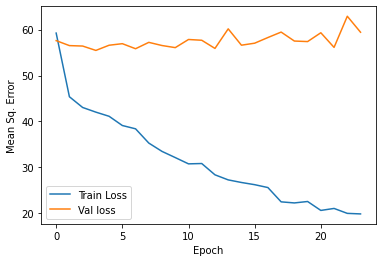

In [116]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [117]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      57


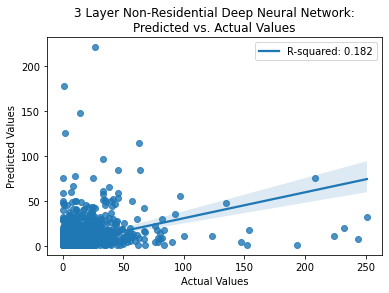

<Figure size 432x288 with 0 Axes>

In [118]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   '3 Layer Non-Residential Deep Neural Network:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/nn3L_nonresidential_system_count_errors')


### 3 Layer Neural Network with Regularization and Dropout

In [123]:
#regularizers.l1_l2(l1=1e-5, l2=1e-4)

#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=.4, l2=3)),
    keras.layers.Dropout(.2),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=.4, l2=3)),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



........................................

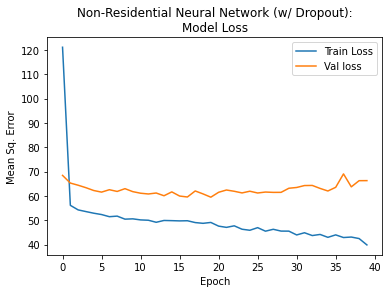

In [124]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history, 'Non-Residential Neural Network (w/ Dropout):\nModel Loss')

In [78]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      50


In [79]:
explainer = shap.KernelExplainer(model.predict,shap.sample(train_data, 100))

In [80]:
shap_values = explainer.shap_values(shap.sample(train_data,100), approximate=True)


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

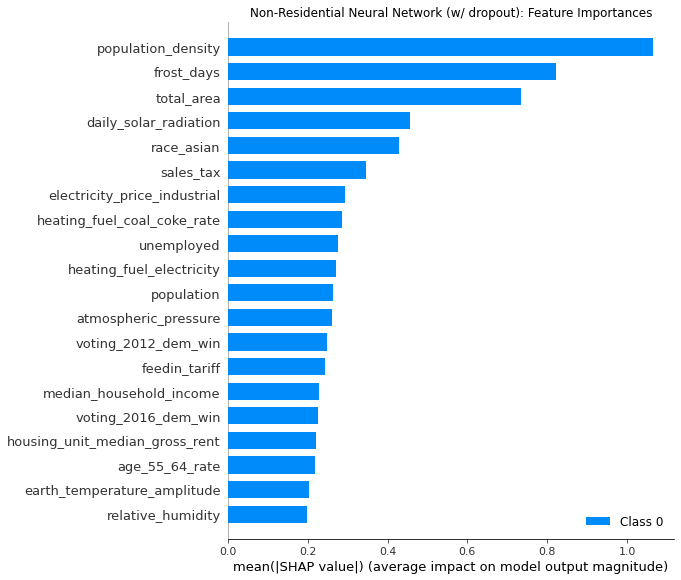

In [127]:
_ = shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns,show=False)
_ = plt.title('Non-Residential Neural Network (w/ dropout): Feature Importances')
_ = plt.show()

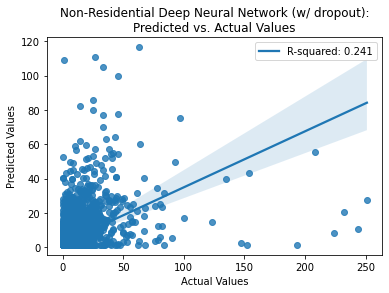

<Figure size 432x288 with 0 Axes>

In [125]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Non-Residential Deep Neural Network (w/ dropout):\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/deep_nn_nonresidential_system_count_errors')
